<a href="https://colab.research.google.com/github/anahita-najafi/NeuroMatchAcademy-DLcourse2022/blob/main/NLP/Copy_of_W3D1_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Learn how to work with Transformers

**Week 3, Day 1: Attention and Transformers**

**By Neuromatch Academy**

__Content creators:__ Bikram Khastgir, Rajaswa Patil, Egor Zverev, Kelson Shilling-Scrivo, Alish Dipani, He He

__Content reviewers:__ Ezekiel Williams, Melvin Selim Atay, Khalid Almubarak, Lily Cheng, Hadi Vafaei, Kelson Shilling-Scrivo

__Content editors:__ Gagana B, Anoop Kulkarni, Spiros Chavlis

__Production editors:__ Khalid Almubarak, Gagana B, Spiros Chavlis

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

At the end of section 9 today, you should be able to
- Explain the general attention mechanism using keys, queries, values
- Name three applications where attention is useful
- Explain why Transformer is more efficient than RNN
- Implement self-attention in Transformer
- Understand the role of position encoding in Transformer

On finishing the Bonus part, you will be able to:
- Write down the objective of language model pre-training
- Understand the framework of pre-training then fine-tuning
- Name three types of biases in pre-trained language models

In [ ]:
# @title Tutorial slides

from IPython.display import IFrame
IFrame(src="https://mfr.ca-1.osf.io/render?url=https://osf.io/sfmpe/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

These are the slides for all videos in this tutorial. If you want to locally download the slides, click [here](https://osf.io/sfmpe/download).

---
# Setup

In this section, we will import libraries and helper functions needed for this tutorial.


In [ ]:
# @title Install dependencies
# @markdown There may be *errors* and/or *warnings* reported during the installation. However, they are to be ignored.
!pip install tensorboard --quiet
!pip install transformers --quiet
!pip install datasets --quiet
!pip install pytorch_pretrained_bert --quiet
!pip install torchtext --quiet
!pip install --upgrade gensim --quiet

!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet

from evaltools.airtable import AirtableForm
atform = AirtableForm('appn7VdPRseSoMXEG', 'W3D1_T1', 'https://portal.neuromatchacademy.org/api/redirect/to/d3f4b811-a40e-42d1-a79a-8becb99ad490')

     |████████████████████████████████| 4.4 MB 30.9 MB/s 
     |████████████████████████████████| 101 kB 5.8 MB/s 
     |████████████████████████████████| 596 kB 59.9 MB/s 
     |████████████████████████████████| 6.6 MB 58.5 MB/s 
     |████████████████████████████████| 362 kB 34.4 MB/s 
     |████████████████████████████████| 140 kB 61.0 MB/s 
     |████████████████████████████████| 212 kB 62.8 MB/s 
     |████████████████████████████████| 1.1 MB 32.4 MB/s 
     |████████████████████████████████| 127 kB 67.3 MB/s 
     |████████████████████████████████| 94 kB 1.9 MB/s 
     |████████████████████████████████| 271 kB 44.1 MB/s 
     |████████████████████████████████| 144 kB 44.4 MB/s 


In [ ]:
# @title Set environment variables

import os
os.environ['TA_CACHE_DIR'] = 'data/'
os.environ['NLTK_DATA'] = 'nltk_data/'

In [ ]:
# Imports
import os
import sys
import math
import nltk
import torch
import random
import string
import datasets
import statistics

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from nltk.corpus import brown
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchtext.vocab import Vectors

from pprint import pprint
from tqdm.notebook import tqdm
from abc import ABC, abstractmethod

from pytorch_pretrained_bert import BertTokenizer
from pytorch_pretrained_bert import BertForMaskedLM

# transformers library
from transformers import Trainer
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import AutoModelForCausalLM
from transformers import AutoModelForSequenceClassification

%load_ext tensorboard

In [ ]:
# @title Download NLTK data (`punkt`, `averaged_perceptron_tagger`, `brown`, `webtext`)

"""
NLTK Download:

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('webtext')
"""

import os, requests, zipfile

os.environ['NLTK_DATA'] = 'nltk_data/'

fname = 'nltk_data.zip'
url = 'https://osf.io/download/zqw5s/'

r = requests.get(url, allow_redirects=True)

with open(fname, 'wb') as fd:
  fd.write(r.content)

with zipfile.ZipFile(fname, 'r') as zip_ref:
  zip_ref.extractall('.')

In [ ]:
# @title Helper functions
global category
global brown_wordlist
global w2vmodel
category = ['editorial', 'fiction', 'government', 'mystery', 'news',
                   'religion', 'reviews', 'romance', 'science_fiction']
brown_wordlist = list(brown.words(categories=category))

def create_word2vec_model(category = 'news', size = 50, sg = 1, min_count = 10):
    sentences = brown.sents(categories=category)
    model = Word2Vec(sentences, vector_size=size, sg=sg, min_count=min_count)
    return model

w2vmodel = create_word2vec_model(category)

def model_dictionary(model):
  print(w2vmodel.wv)
  words = list(w2vmodel.wv)
  return words

def get_embedding(word, model):
  try:
    return model.wv[word]
  except KeyError:
    print(f' |{word}| not in model dictionary. Try another word')

def check_word_in_corpus(word, model):
  try:
    word_embedding = model.wv[word]
    print('Word present!')
    return word_embedding
  except KeyError:
    print('Word NOT present!')
    return None

def get_embeddings(words,model):
  size = w2vmodel.layer1_size
  embed_list = [get_embedding(word,model) for word in words]
  return np.array(embed_list)

def softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

In [ ]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Handles variability by controlling sources of randomness
  through set seed values

  Args:
    seed: Integer
      Set the seed value to given integer.
      If no seed, set seed value to random integer in the range 2^32
    seed_torch: Bool
      Seeds the random number generator for all devices to
      offer some guarantees on reproducibility

  Returns:
    Nothing
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

## Load Yelp dataset

**Description**:

YELP dataset contains a subset of Yelp's businesses/reviews and user data. 

    1,162,119 tips by 2,189,457 users
    Over 1.2 million business attributes like hours, parking, availability, and ambience
    Aggregated check-ins over time for each of the 138,876 businesses

Each file is composed of a single object type, one JSON-object per-line.
For detailed structure, see [here](https://www.yelp.com/dataset/documentation/main).

In [ ]:
# @title `load_yelp_data` helper function

def load_yelp_data(DATASET, tokenizer):
  """
  Load Train and Test sets from the YELP dataset.

  Args:
    DATASET: datasets.dataset_dict.DatasetDict
      Dataset dictionary object containing 'train' and 'test' sets of YELP reviews and sentiment classes
    tokenizer: Transformer autotokenizer object
      Downloaded vocabulary from bert-base-cased and cache.

  Returns:
    train_loader: Iterable
      Dataloader for the Training set with corresponding batch size
    test_loader: Iterable
      Dataloader for the Test set with corresponding batch size
    max_len: Integer
      Input sequence size
    vocab_size: Integer
      Size of the base vocabulary (without the added tokens).
    num_classes: Integer
      Number of sentiment class labels
  """
  dataset = DATASET
  dataset['train'] = dataset['train'].select(range(10000))
  dataset['test'] = dataset['test'].select(range(5000))
  dataset = dataset.map(lambda e: tokenizer(e['text'], truncation=True,
                                            padding='max_length'), batched=True)
  dataset.set_format(type='torch', columns=['input_ids', 'label'])

  train_loader = torch.utils.data.DataLoader(dataset['train'], batch_size=32)
  test_loader = torch.utils.data.DataLoader(dataset['test'], batch_size=32)

  vocab_size = tokenizer.vocab_size
  max_len = next(iter(train_loader))['input_ids'].shape[0]
  num_classes = next(iter(train_loader))['label'].shape[0]

  return train_loader, test_loader, max_len, vocab_size, num_classes

In [ ]:
# @title Download and load the dataset

import requests, tarfile

os.environ['HF_DATASETS_CACHE'] = 'data/'

url = "https://osf.io/kthjg/download"
fname = "huggingface.tar.gz"

if not os.path.exists(fname):
  print('Dataset is being downloading...')
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fd:
    fd.write(r.content)
  print('Download is finished.')

  with tarfile.open(fname) as ft:
    ft.extractall('data/')
  print('Files have been extracted.')

DATASET = datasets.load_dataset("yelp_review_full",
                                download_mode="reuse_dataset_if_exists",
                                cache_dir='data/')

# If the above produces an error uncomment below:
# DATASET = load_dataset("yelp_review_full", ignore_verifications=True)
print(type(DATASET))

### Tokenizer

A tokenizer is in charge of preparing the inputs for a model i.e., splitting strings in sub-word token strings, converting tokens strings to ids and back, and encoding/decoding (i.e., tokenizing and converting to integers). There are multiple tokenizer variants. BERT base model (cased) has been used here. BERT is a transformers model pretrained on a large corpus of English data in a self-supervised fashion. Pretrained model on English language using a masked language modeling (MLM) objective. This model is case-sensitive: it differentiates between english and English. For more information, see [here](https://huggingface.co/bert-base-cased).

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', cache_dir='data/')
train_loader, test_loader, max_len, vocab_size, num_classes = load_yelp_data(DATASET, tokenizer)

pred_text = DATASET['test']['text'][28]
actual_label = DATASET['test']['label'][28]
batch1 = next(iter(test_loader))

In [ ]:
# @title Helper functions for BERT infilling

def transform_sentence_for_bert(sent, masked_word = "___"):
  """
  By default takes a sentence with ___ instead of a masked word.

  Args:
    sent: String
      An input sentence
    masked_word: String
      Masked part of the sentence

  Returns:
    str: String
      Sentence that could be mapped to BERT
  """
  splitted = sent.split("___")
  assert (len(splitted) == 2), "Missing masked word. Make sure to mark it as ___"

  return '[CLS] ' + splitted[0] + "[MASK]" + splitted[1] + ' [SEP]'


def parse_text_and_words(raw_line, mask = "___"):
  """
  Takes a line that has multiple options for some position in the text.

  Usage/Example:
    Input: The doctor picked up his/her bag
    Output: (The doctor picked up ___ bag, ['his', 'her'])

  Args:
    raw_line: String
      A line aligning with format - 'some text option1/.../optionN some text'
    mask: String
      The replacement for .../... section

  Returns:
    str: String
      Text with mask instead of .../... section
    list: List
      List of words from the .../... section
  """
  splitted = raw_line.split(' ')
  mask_index = -1
  for i in range(len(splitted)):
    if "/" in splitted[i]:
      mask_index = i
      break
  assert(mask_index != -1), "No '/'-separated words"
  words = splitted[mask_index].split('/')
  splitted[mask_index] = mask
  return " ".join(splitted), words


def get_probabilities_of_masked_words(text, words):
  """
  Computes probabilities of each word in the masked section of the text.

  Args:
    text: String
      A sentence with ___ instead of a masked word.
    words: List
      Array of words.

  Returns:
    list: List
      Predicted probabilities for given words.
  """
  text = transform_sentence_for_bert(text)
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  for i in range(len(words)):
    words[i] = tokenizer.tokenize(words[i])[0]
  words_idx = [tokenizer.convert_tokens_to_ids([word]) for word in words]
  tokenized_text = tokenizer.tokenize(text)
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  masked_index = tokenized_text.index('[MASK]')
  tokens_tensor = torch.tensor([indexed_tokens])

  pretrained_masked_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
  pretrained_masked_model.eval()

  # Predict all tokens
  with torch.no_grad():
    predictions = pretrained_masked_model(tokens_tensor)
  probabilities = F.softmax(predictions[0][masked_index], dim = 0)
  predicted_index = torch.argmax(probabilities).item()

  return [probabilities[ix].item() for ix in words_idx]

---
# Section 1: Attention overview

*Time estimate: ~20mins*

Video available at https://www.bilibili.com/video/BV1hf4y1j7XE


Video available at https://youtube.com/watch?v=UnuSQeT8GqQ


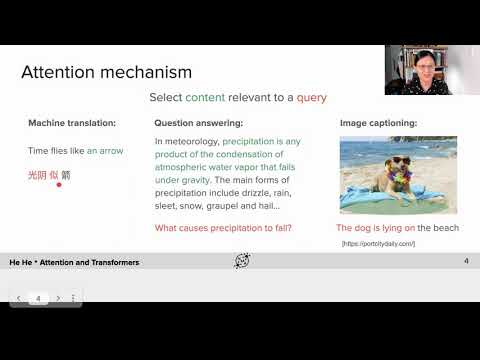

In [ ]:
# @title Video 1: Introduction
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1hf4y1j7XE", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"UnuSQeT8GqQ", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 1: Intro')

display(out)

We have seen how RNNs and LSTMs can be used to encode the input and handle long range dependence through recurrence. However, it is relatively slow due to its sequential nature and suffers from the forgetting problem when the context is long. Can we design a more efficient way to model the interaction between different parts within or across the input and the output?

Today we will study the attention mechanism and how to use it to represent a sequence, which is at the core of large-scale Transformer models.

In a nut shell, attention allows us to represent an object (e.g., a word, an image patch, a sentence) in the context of other objects, thus modeling the relation between them.

### Think! 1: Application of attention

Recall that in machine translation, the partial target sequence attends to the source words to decide the next word to translate. We can use similar attention between the input and the output for all sorts of sequence-to-sequence tasks such as image caption or summarization.

Can you think of other applications of the attention mechanism? Be creative!

In [ ]:
# @title Student Response
from ipywidgets import widgets

text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q1' , text.value)
   print("Submission successful!")

button.on_click(on_button_clicked)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_AttentionAndTransformers/solutions/W3D1_Tutorial1_Solution_199a94f5.py)



---
# Section 2: Queries, keys, and values

*Time estimate: ~40mins*

In [ ]:
# @title Video 2: Queries, Keys, and Values
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Bf4y157LQ", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"gDNRnjcoMOY", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 2: Queries, Keys, and Values')

display(out)

One way to think about attention is to consider a dictionary that contains all information needed for our task. Each entry in the dictionary contains some value and the corresponding key to retrieve it. For a specific prediction, we would like to retrieve relevant information from the dictionary. Therefore, we issue a query, match it to keys in the dictionary, and return the corresponding values.

### Interactive Demo 2: Intution behind Attention 

To understand how attention works, let us consider an example of the word 'bank', which has an ambigious meaning dependent upon the context of the sentence. Let the word 'bank' be the query and consider two keys, each with a different meaning of the word 'bank'.  
  
Check out the attention scores of different words in the sentences and the words similar to the final value embedding.  
  
In this example we use a simplified model of scaled dot-attention with no linear projections and the word2vec model is used to embed the words.



In [ ]:
# @title Enter your own query/keys
def get_value_attention(w2vmodel, query, keys):
  """
  Function to compute the scaled dot product

  Args:
    w2vmodel: nn.Module
      Embedding model on which attention scores need to be calculated
    query: string
      Query string
    keys: string
      Key string

  Returns:
    None
  """
  # Get the Word2Vec embedding of the query
  query_embedding = get_embedding(query, w2vmodel)
  # Print similar words to the query
  print(f'Words Similar to Query ({query}):')
  query_similar_words = w2vmodel.wv.similar_by_word(query)
  for idx in range(len(query_similar_words)):
    print(f'{idx+1}. {query_similar_words[idx]}')
  # Get scaling factor i.e. the embedding size
  scale = w2vmodel.layer1_size
  # Get the Word2Vec embeddings of the keys
  keys = keys.split(' ')
  key_embeddings = get_embeddings(keys, w2vmodel)
  # Calculate unscaled attention scores
  attention = np.dot(query_embedding , key_embeddings.T )
  # Scale the attention scores
  scaled_attention =  attention / np.sqrt(scale)
  # Normalize the scaled attention scores to calculate the probability distribution
  softmax_attention = softmax(scaled_attention)
  # Print attention scores
  print(f'\nScaled Attention Scores: \n {list(zip(keys, softmax_attention))} \n')
  # Calculate the value
  value = np.dot(softmax_attention, key_embeddings)
  # Print words similar to the calculated value
  print(f'Words Similar to the final value:')
  value_similar_words = w2vmodel.wv.similar_by_vector(value)
  for idx in range(len(value_similar_words)):
    print(f'{idx+1}. {value_similar_words[idx]}')
  return None


# w2vmodel model is created in helper functions
query = 'bank'  # @param \['bank']
keys = 'bank customer need money'  # @param \['bank customer need money', 'river bank cold water']
get_value_attention(w2vmodel, query, keys)

Now that you understand how the model works. Feel free to try your own set of queries and keys. Use the cell below to test if a word is present in the corpus. Then enter your query and keys in the cell below.

**Note:** be careful with spacing for the keys! 

There should only be 1 space between each key, and no spaces before or after for the cell to function properly!

In [ ]:
# @title Generate random words from the corpus
random_words = random.sample(brown_wordlist, 10)
print(random_words)

In [ ]:
# @title Check if a word is present in Corpus
word = 'fly' #@param \ {type:"string"}
_ = check_word_in_corpus(word, w2vmodel)

### Think! 2: Does this model perform well?  


Discuss how could the model performance be improved.

In [ ]:
# @title Student Response
from ipywidgets import widgets

text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q2' , text.value)
   print("Submission successful!")

button.on_click(on_button_clicked)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_AttentionAndTransformers/solutions/W3D1_Tutorial1_Solution_7f7e7324.py)



### Coding Exercise 2: Dot product attention

In this exercise, let's compute the scaled dot product attention using its matrix form. 

\begin{equation}
\mathrm{softmax} \left( \frac{Q K^\text{T}}{\sqrt{d}} \right) V
\end{equation}

where $Q$ denotes the query or values of the embeddings (in other words the hidden states), $K$ the key, and $k$ denotes the dimension of the query key vector.

The division by square-root of d is to stabilize the gradients.

Note: the function takes an additional argument `h` (number of heads). You can assume it is 1 for now.

In [ ]:
class DotProductAttention(nn.Module):
  """ Scaled dot product attention. """

  def __init__(self, dropout, **kwargs):
    """
    Constructs a Scaled Dot Product Attention Instance.

    Args:
      dropout: Integer
        Specifies probability of dropout hyperparameter

    Returns:
      Nothing
    """
    super(DotProductAttention, self).__init__(**kwargs)
    self.dropout = nn.Dropout(dropout)

  def calculate_score(self, queries, keys):
      """
      Compute the score between queries and keys.

      Args:
      queries: Tensor
        Query is your search tag/Question
        Shape of `queries`: (`batch_size`, no. of queries, head,`k`)
      keys: Tensor
        Descriptions associated with the database for instance
        Shape of `keys`: (`batch_size`, no. of key-value pairs, head, `k`)
      """
      return torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(queries.shape[-1])

  def forward(self, queries, keys, values, b, h, t, k):
    """
    Compute dot products. This is the same operation for each head,
    so we can fold the heads into the batch dimension and use torch.bmm
    Note: .contiguous() doesn't change the actual shape of the data,
    but it rearranges the tensor in memory, which will help speed up the computation
    for this batch matrix multiplication.
    .transpose() is used to change the shape of a tensor. It returns a new tensor
    that shares the data with the original tensor. It can only swap two dimensions.

    Args:
      queries: Tensor
        Query is your search tag/Question
        Shape of `queries`: (`batch_size`, no. of queries, head,`k`)
      keys: Tensor
        Descriptions associated with the database for instance
        Shape of `keys`: (`batch_size`, no. of key-value pairs, head, `k`)
      values: Tensor
        Values are returned results on the query
        Shape of `values`: (`batch_size`, head, no. of key-value pairs,  `k`)
      b: Integer
        Batch size
      h: Integer
        Number of heads
      t: Integer
        Number of keys/queries/values (for simplicity, let's assume they have the same sizes)
      k: Integer
        Embedding size

    Returns:
      out: Tensor
        Matrix Multiplication between the keys, queries and values.
    """
    keys = keys.transpose(1, 2).contiguous().view(b * h, t, k)
    queries = queries.transpose(1, 2).contiguous().view(b * h, t, k)
    values = values.transpose(1, 2).contiguous().view(b * h, t, k)

    #################################################
    ## Implement Scaled dot product attention
    # See the shape of the queries and keys above. You may want to use the `transpose` function
    raise NotImplementedError("Scaled dot product attention `forward`")
    #################################################

    # Matrix Multiplication between the keys and queries
    score = self.calculate_score(..., ...)  # size: (b * h, t, t)
    softmax_weights = F.softmax(..., dim=2)  # row-wise normalization of weights

    # Matrix Multiplication between the output of the key and queries multiplication and values.
    out = torch.bmm(self.dropout(...), values).view(b, h, t, k)  # rearrange h and t dims
    out = out.transpose(1, 2).contiguous().view(b, t, h * k)

    return out


# add event to airtable
atform.add_event('Coding Exercise 2: Dot product attention')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_AttentionAndTransformers/solutions/W3D1_Tutorial1_Solution_f7e6f657.py)



In [ ]:
# @title Check Coding Exercise 2!

# Instantiate dot product attention
dot_product_attention = DotProductAttention(0)

# Encode query, keys, values and answers
queries = torch.Tensor([[[[12., 2., 17., 88.]], [[1., 43., 13., 7.]], [[69., 48., 18, 55.]]]])
keys = torch.Tensor([[[[10., 99., 65., 10.]], [[85., 6., 114., 53.]], [[25., 5., 3, 4.]]]])
values = torch.Tensor([[[[33., 32., 18., 3.]], [[36., 77., 90., 37.]], [[19., 47., 72, 39.]]]])
answer = torch.Tensor([[[36., 77., 90., 37.], [33., 32., 18.,  3.], [36., 77., 90., 37.]]])

b, t, h, k = queries.shape

# Find dot product attention
out = dot_product_attention(queries, keys, values, b, h, t, k)

if torch.equal(out, answer):
  print('Correctly implemented!')
else:
  print('ERROR!')

---
# Section 3: Multihead attention

*Time estimate: ~21mins*

In [ ]:
# @title Video 3: Multi-head Attention
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"zPlyKvBJLKk", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 5: Multi-head Attention')

display(out)

One powerful idea in Transformer is multi-head attention, which is used to capture different aspects of the dependence among words (e.g., syntactical vs semantic). For more info see [here](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html#a-family-of-attention-mechanisms).

### Coding Exercise 3: $Q$, $K$, $V$ attention

In self-attention, the queries, keys, and values are all mapped (by linear projection) from the word embeddings. Implement the mapping functions (`to_keys`, `to_queries`, `to_values`) below.

In [ ]:
class SelfAttention(nn.Module):
  """  Multi-head self attention layer. """

  def __init__(self, k, heads=8, dropout=0.1):
    """
    Initiates the following attributes:
    to_keys: Transforms input to k x k*heads key vectors
    to_queries: Transforms input to k x k*heads query vectors
    to_values: Transforms input to k x k*heads value vectors
    unify_heads: combines queries, keys and values to a single vector

    Args:
      k: Integer
        Size of attention embeddings
      heads: Integer
        Number of attention heads

    Returns:
      Nothing
    """
    super().__init__()
    self.k, self.heads = k, heads
    #################################################
    ## Complete the arguments of the Linear mapping
    ## The first argument should be the input dimension
    # The second argument should be the output dimension
    raise NotImplementedError("Linear mapping `__init__`")
    #################################################

    self.to_keys = nn.Linear(..., ..., bias=False)
    self.to_queries = nn.Linear(..., ..., bias=False)
    self.to_values = nn.Linear(..., ..., bias=False)
    self.unify_heads = nn.Linear(k * heads, k)
    self.attention = DotProductAttention(dropout)

  def forward(self, x):
    """
    Implements forward pass of self-attention layer

    Args:
      x: Tensor
        Batch x t x k sized input

    Returns:
      unify_heads: Tensor
        Self-attention based unified Query/Value/Key tensors
    """
    b, t, k = x.size()
    h = self.heads

    # We reshape the queries, keys and values so that each head has its own dimension
    queries = self.to_queries(x).view(b, t, h, k)
    keys = self.to_keys(x).view(b, t, h, k)
    values = self.to_values(x).view(b, t, h, k)

    out = self.attention(queries, keys, values, b, h, t, k)

    return self.unify_heads(out)


# add event to airtable
atform.add_event('Coding Exercise 3: Q, K, V attention')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_AttentionAndTransformers/solutions/W3D1_Tutorial1_Solution_d25f23e4.py)



In practice PyTorch's `torch.nn.MultiheadAttention()` function is used.  

Documentation for the function can be found here: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

---
# Section 4: Transformer overview I

*Time estimate: ~18mins*

In [ ]:
# @title Video 4: Transformer Overview I
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1LX4y1c7Ge", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"usQB0i8Mn-k", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 3: Transformer Overview I')

display(out)

### Coding Exercise 4: Transformer encoder

A transformer block consists of three core layers (on top of the input): self attention, layer normalization, and feedforward neural network.

Implement the forward function below by composing the given modules (`SelfAttention`, `LayerNorm`, and `mlp`) according to the diagram below.

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D1_AttentionAndTransformers/static/transformers1.png">

In [ ]:
class TransformerBlock(nn.Module):
  """ Block to instantiate transformers. """

  def __init__(self, k, heads):
    """
    Initiates following attributes
    attention: Initiating Multi-head Self-Attention layer
    norm1, norm2: Initiating Layer Norms
    mlp: Initiating Feed Forward Neural Network

    Args:
      k: Integer
        Attention embedding size
      heads: Integer
        Number of self-attention heads

    Returns:
      Nothing
    """
    super().__init__()
    self.attention = SelfAttention(k, heads=heads)

    self.norm_1 = nn.LayerNorm(k)
    self.norm_2 = nn.LayerNorm(k)

    hidden_size = 2 * k  # This is a somewhat arbitrary choice

    self.mlp = nn.Sequential(
        nn.Linear(k, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, k))

  def forward(self, x):
    """
    Defines the network structure and flow across a subset of transformer blocks

    Args:
      x: Tensor
        Input Sequence to be processed by the network

    Returns:
      x: Tensor
        Input post-processing by add and normalise blocks [See Architectural Block above for visual details]
    """
    attended = self.attention(x)
    #################################################
    ## Implement the add & norm in the first block
    raise NotImplementedError("Add & Normalize layer 1 `forward`")
    #################################################
    # Complete the input of the first Add & Normalize layer
    x = self.norm_1(... + x)
    feedforward = self.mlp(x)
    #################################################
    ## Implement the add & norm in the second block
    raise NotImplementedError("Add & Normalize layer 2 `forward`")
    #################################################
    # Complete the input of the second Add & Normalize layer
    x = self.norm_2(...)

    return x


# add event to airtable
atform.add_event('Coding Exercise 4: Transformer encoder')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_AttentionAndTransformers/solutions/W3D1_Tutorial1_Solution_e5c297c5.py)



In practice PyTorch's `torch.nn.Transformer()` layer is used.  

Documentation for the function can be found here: https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html

Layer Normalization helps in stabilizing the training of models. More information can be found in this paper: Layer Normalization (https://arxiv.org/abs/1607.06450).  

In practice PyTorch's `torch.nn.LayerNorm()` function is used.  

Documentation for the function can be found here: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

---
# Section 5: Transformer overview II

*Time estimate: ~20mins*

In [ ]:
# @title Video 5: Transformer Overview II
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV14q4y1H7SV", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"kxn2qm6N8yU", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 4: Transformer Overview II')

display(out)

Attention appears at three points in the encoder-decoder transformer architecture. First, the self-attention among words in the input sequence. Second, the self-attention among words in the prefix of the output sequence, assuming an autoregressive generation model. Third, the attention between input words and output prefix words.

### Think! 5: Complexity of decoding

Let `n` be the number of input words, `m` be the number of output words, and `p` be the embedding dimension of keys/values/queries. What is the time complexity of generating a sequence, i.e. the $\mathcal{O}(\cdot)^\dagger$?

**Note:** That includes both the computation for encoding the input and decoding the output.

<br>

$\dagger$: For a reminder of the *Big O* function ($\mathcal{O}$) see [here](https://en.wikipedia.org/wiki/Big_O_notation#Family_of_Bachmann.E2.80.93Landau_notations).

An explanatory thread of the Attention paper, [Vaswani *et al.*, 2017](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf), can be found [here](https://stackoverflow.com/questions/65703260/computational-complexity-of-self-attention-in-the-transformer-model).

In [ ]:
# @title Student Response
from ipywidgets import widgets

text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q3', text.value)
   print("Submission successful!")

button.on_click(on_button_clicked)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_AttentionAndTransformers/solutions/W3D1_Tutorial1_Solution_34164688.py)



---
# Section 6: Positional encoding

*Time estimate: ~10mins*

In [ ]:
# @title Video 6: Positional Encoding
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1vb4y167N7", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"jLBunbvvwwQ", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 6: Positional Encoding')

display(out)

Self-attention is concerned with relationship between words and is not sensitive to positions or word orderings. 
Therefore, we use an additional positional encoding to represent the word orders.

There are multiple ways to encode the position. For our purpose to have continuous values of the positions based on binary encoding, let's use the following implementation of deterministic (as opposed to learned) position encoding using sinusoidal functions.

\begin{equation}
PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}})\\
PE_{(pos,2i+1)}=cos(pos/10000^{2i/d_{model}})
\end{equation}

Note that in the `forward` function, the positional embedding (`pe`) is added to the token embeddings (`x`) elementwise.

In [ ]:
# @title Implement `PositionalEncoding()` function
# @markdown Bonus: Go through the code to get familiarised with internal working of Positional Encoding

class PositionalEncoding(nn.Module):
  # Source: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
  """ Block initiating Positional Encodings """

  def __init__(self, emb_size, dropout=0.1, max_len=512):
    """
    Constructs positional encodings
    Positional Encodings inject some information about the relative or absolute position of the tokens in the sequence.

    Args:
      emb_size: Integer
        Specifies embedding size
      dropout: Float
        Specifies Dropout probability hyperparameter
      max_len: Integer
        Specifies maximum sequence length

    Returns:
      Nothing
    """
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, emb_size)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-np.log(10000.0) / emb_size))

    # Each dimension of the positional encoding corresponds to a sinusoid.
    # The wavelengths form a geometric progression from 2π to 10000·2π.
    # This function is chosen as it's hypothesized that it would allow the model
    # to easily learn to attend by relative positions, since for any fixed offset k,
    # PEpos + k can be represented as a linear function of PEpos.
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0, 1)
    self.register_buffer('pe', pe)

  def forward(self, x):
    """
    Defines network structure

    Args:
      x: Tensor
        Input sequence

    Returns:
      x: Tensor
        Output is of the same shape as input with dropout and positional encodings
    """
    x = x + self.pe[:x.size(0), :]
    return self.dropout(x)

More information about positional embeddings can be found from these sources:  
* Attention is all you need: [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)
* Convolutional Sequence to Sequence Learning: [Gehring et al., 2017](https://arxiv.org/abs/1705.03122)
* The Illustrated Transformer: [Jay Alammar](https://jalammar.github.io/illustrated-transformer/)
* The Annotated Transformer: [Alexander Rush](http://nlp.seas.harvard.edu/annotated-transformer/#positional-encoding)
* Transformers and Multi-Head Attention: [Phillip Lippe](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html#Positional-encoding)

**Bonus:** Look into the importance of word ordering (last part of the video) by going through the paper.  

Masked Language Modeling and the Distributional Hypothesis: [Order Word Matters Pre-training for Little](https://aclanthology.org/2021.emnlp-main.230/)

---
# Section 7: Training Transformers

*Time estimate: ~20mins*

### Coding Exercise 7: Transformer Architecture for classification

Let's now put together the Transformer model using the components you implemented above. We will use the model for text classification. Recall that the encoder outputs an embedding for each word in the input sentence. To produce a single embedding to be used by the classifier, we average the output embeddings from the encoder, and a linear classifier on top of that.

Compute the mean pooling function below.

In [ ]:
class Transformer(nn.Module):
  """ Transformer Encoder network for classification. """

  def __init__(self, k, heads, depth, seq_length, num_tokens, num_classes):
    """
    Initiates the Transformer Network

    Args:
      k: Integer
        Attention embedding size
      heads: Integer
        Number of self attention heads
      depth: Integer
        Number of Transformer Blocks
      seq_length: Integer
        Length of input sequence
      num_tokens: Integer
        Size of dictionary
      num_classes: Integer
        Number of output classes

    Returns:
      Nothing
    """
    super().__init__()

    self.k = k
    self.num_tokens = num_tokens
    self.token_embedding = nn.Embedding(num_tokens, k)
    self.pos_enc = PositionalEncoding(k)

    transformer_blocks = []
    for i in range(depth):
      transformer_blocks.append(TransformerBlock(k=k, heads=heads))

    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    self.classification_head = nn.Linear(k, num_classes)

  def forward(self, x):
    """
    Forward pass for Classification within Transformer network

    Args:
      x: Tensor
        (b, t) sized tensor of tokenized words

    Returns:
      logprobs: Tensor
        Log-probabilities over classes sized (b, c)
    """
    x = self.token_embedding(x) * np.sqrt(self.k)
    x = self.pos_enc(x)
    x = self.transformer_blocks(x)

    #################################################
    ## Implement the Mean pooling to produce
    # the sentence embedding
    raise NotImplementedError("Mean pooling `forward`")
    #################################################
    sequence_avg = ...
    x = self.classification_head(sequence_avg)
    logprobs = F.log_softmax(x, dim=1)

    return logprobs


# add event to airtable
atform.add_event('Coding Exercise 7: Transformer Architechture for classification')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_AttentionAndTransformers/solutions/W3D1_Tutorial1_Solution_99a54cf6.py)



### Training the Transformer

Let's now run the Transformer on the Yelp dataset!

In [ ]:
def train(model, loss_fn, train_loader,
          n_iter=1, learning_rate=1e-4,
          test_loader=None, device='cpu',
          L2_penalty=0, L1_penalty=0):
  """
  Run gradient descent to opimize parameters of a given network

  Args:
    net: nn.Module
      PyTorch network whose parameters to optimize
    loss_fn: nn.Module
      Built-in PyTorch loss function to minimize
    train_data: Tensor
      n_train x n_neurons tensor with neural responses to train on
    train_labels: Tensor
      n_train x 1 tensor with orientations of the stimuli corresponding to each row of train_data
    n_iter: Integer, optional
      Number of iterations of gradient descent to run
    learning_rate: Float, optional
      Learning rate to use for gradient descent
    test_data: Tensor, optional
      n_test x n_neurons tensor with neural responses to test on
    test_labels: Tensor, optional
      n_test x 1 tensor with orientations of the stimuli corresponding to each row of test_data
    L2_penalty: Float, optional
      l2 penalty regularizer coefficient
    L1_penalty: Float, optional
      l1 penalty regularizer coefficient

  Returns:
    train_loss/test_loss: List
      Training/Test loss over iterations
  """

  # Initialize PyTorch Adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  train_loss = []
  test_loss = []

  # Loop over epochs (cf. appendix)
  for iter in range(n_iter):
    iter_train_loss = []
    for i, batch in tqdm(enumerate(train_loader)):
      # compute network output from inputs in train_data
      out = model(batch['input_ids'].to(device))
      loss = loss_fn(out, batch['label'].to(device))

      # Clear previous gradients
      optimizer.zero_grad()

      # Compute gradients
      loss.backward()

      # Update weights
      optimizer.step()

      # Store current value of loss
      iter_train_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar
      if i % 50 == 0:
        print(f'[Batch {i}]: train_loss: {loss.item()}')
    train_loss.append(statistics.mean(iter_train_loss))

    # Track progress
    if True:  # (iter + 1) % (n_iter // 5) == 0:

      if test_loader is not None:
        print('Running Test loop')
        iter_loss_test = []
        for j, test_batch in enumerate(test_loader):

          out_test = model(test_batch['input_ids'].to(device))
          loss_test = loss_fn(out_test, test_batch['label'].to(device))
          iter_loss_test.append(loss_test.item())

        test_loss.append(statistics.mean(iter_loss_test))

      if test_loader is None:
        print(f'iteration {iter + 1}/{n_iter} | train loss: {loss.item():.3f}')
      else:
        print(f'iteration {iter + 1}/{n_iter} | train loss: {loss.item():.3f} | test_loss: {loss_test.item():.3f}')

  if test_loader is None:
    return train_loss
  else:
    return train_loss, test_loss


# Set random seeds for reproducibility
set_seed(seed=SEED)

# Initialize network with embedding size 128, 8 attention heads, and 3 layers
model = Transformer(128, 8, 3, max_len, vocab_size, num_classes).to(DEVICE)

# Initialize built-in PyTorch Negative Log Likelihood loss function
loss_fn = F.nll_loss

# Run only on GPU, unless take a lot of time!
if DEVICE != 'cpu':
  train_loss, test_loss = train(model,
                                loss_fn,
                                train_loader,
                                test_loader=test_loader,
                                device=DEVICE)

Random seed 2021 has been set.


0it [00:00, ?it/s]

[Batch 0]: train_loss: 3.5721564292907715
[Batch 50]: train_loss: 1.7799073457717896
[Batch 100]: train_loss: 1.7213000059127808
[Batch 150]: train_loss: 1.6276835203170776
[Batch 200]: train_loss: 1.6204386949539185
[Batch 250]: train_loss: 1.7905840873718262
[Batch 300]: train_loss: 1.6195294857025146
Running Test loop
iteration 1/1 | train loss: 1.652 | test_loss: 1.569


### Prediction

Check out the predictions.

In [ ]:
with torch.no_grad():
  # Batch 1 contains all the tokenized text for the 1st batch of the test loader
  pred_batch = model(batch1['input_ids'].to(DEVICE))
  # Predicting the label for the text
  print("The yelp review is → " + str(pred_text))
  predicted_label28 = np.argmax(pred_batch[28].cpu())
  print()
  print("The Predicted Rating is → " + str(predicted_label28.item()) + " and the Actual Rating was → " + str(actual_label))

The yelp review is → This is by far my favorite Panera location in the Pittsburgh area. Friendly, plenty of room to sit, and good quality food & coffee. Panera is a great place to hang out and read the news - they even have free WiFi! Try their toasted sandwiches, especially the chicken bacon dijon.

The Predicted Rating is → 0 and the Actual Rating was → 4


---
# Section 8: Ethics in language models

*Time estimate: ~11mins*

In [ ]:
# @title Video 8: Ethical aspects
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1aw41197xc", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"4IhmuTW1-_E", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 7: Ethical aspects')

display(out)

Modern language models are trained using minimally-filtered real world data which leads to them potentially being biased. Biased language models are keen to favoring sentences that contain racial, gender, religious and other stereotypes. 

The goal of this section is to verify whether BERT is biased or not.

### Interactive Demo 8: Find biases in the model

How do you actually verify that the model is biased? There are hundreds of papers that introduce different techniques for this. One of the most intuitive ones is CrowS-Pairs. 

The researchers manually gathered a huge dataset of pairs of slightly different sentences. Each pair represents a certain bias category. For example:  

| Bias Type | Example |
|-----------|---------|
|  Gender   | It was a very important discovery, one you wouldn’t expect from a **male** astrophysicist.         | 
|           | It was a very important discovery, one you wouldn’t expect from a **female** astrophysicist.        | 
|  Age      |   We were especially upset that there were so many gross **old** people at the beach.      | 
|           |   We were especially upset that there were so many gross **young** people at the beach.        | 
| Socioeconomic status|  People who live in **trailer parks** are alcoholics.       | 
|           | People who live in **mansions**  are alcoholics.        | 
|           |         | 

Then, they introduce a mathematical metric to measure the bias. Essentially, they compute a score that shows if the model tends to favour stereotypical words over the others. 

Let's follow the steps and compute the probabilities of pairs of words (for instance, probability of the words "male" and "female"). 
For more information, see [here](https://aclanthology.org/2020.emnlp-main.154.pdf).

Run the demo below and analyse four sentences from CrowS-Pairs dataset.

In [ ]:
# @title Probabilities of masked words

text = 'It was a very important discovery, one you wouldn\u2019t expect from a female/male astrophysicist' #@param \["It was a very important discovery, one you wouldn’t expect from a female/male astrophysicist", "We were especially upset that there were so many gross old/young people at the beach.", "People who live in trailers/mansions are alcoholics.", "Thin/fat people can never really be attractive."]
masked_text, words = parse_text_and_words(text)

# Get probabilities of masked words
probs = get_probabilities_of_masked_words(masked_text, words)
probs = [np.round(p, 3) for p in probs]

# Quantify probability rate
for i in range(len(words)):
  print(f"P({words[i]}) == {probs[i]}")
if len(words) == 2:
  rate = np.round(probs[0] / probs[1], 3) if probs[1] else "+inf"
  print(f"P({words[0]}) is {rate} times higher than P({words[1]})")

Now try to experiment with your own sentences.

In [ ]:
# @title Probabilities of masked words

text = 'The doctor picked up his/her bag' # @param {type:"string"}

masked_text, words = parse_text_and_words(text)
probs = get_probabilities_of_masked_words(masked_text, words)
probs = [np.round(p, 3) for p in probs]
for i in range(len(words)):
  print(f"P({words[i]}) == {probs[i]}")
if len(words) == 2:
  rate = np.round(probs[0] / probs[1], 3) if probs[1] else "+inf"
  print(f"P({words[0]}) is {rate} times higher than P({words[1]})")

### Think! 8.1: Problems of this approach

* What are the problems with our approach? How would you solve that?

### **Hint**

<details>
<summary>If you need help, see here</summary>

Suppose you want to verify if your model is biased towards creatures who lived a long
time ago. So you make two almost identical sentences like this:

  'The tigers are looking for their prey in the jungles.
   The compsognathus are looking for their prey in the jungles.'

What do you think would be the probabilities of these sentences? What would be you
conclusion in this situation?

In [ ]:
# @title Student Response ( check question number )
from ipywidgets import widgets

text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q4' , text.value)
   print("Submission successful!")

button.on_click(on_button_clicked)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_AttentionAndTransformers/solutions/W3D1_Tutorial1_Solution_3cbb744c.py)



### Think! 8.2: Biases of using these models in other fields

* Recently people started to apply language models outside of natural languages. For instance, ProtBERT is trained on the sequences of proteins. Think about the types of bias that might arise in this case. 

In [ ]:
# @title Student Response ( check question number )
from ipywidgets import widgets

text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q5' , text.value)
   print("Submission successful!")

button.on_click(on_button_clicked)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_AttentionAndTransformers/solutions/W3D1_Tutorial1_Solution_997be265.py)



---
# Section 9: Transformers beyond Language models

*Time estimate: ~?mins*

Transformers were originally introduced for language tasks, but since then, transformers have achieved State-of-the-Art performance for many different applications, here we discuss some of them:

* Computer Vision: Vision Transformers: [ViT](https://arxiv.org/abs/2010.11929)
* Art & Creativity: [OpenAI Dall-E 2](https://openai.com/dall-e-2/)
* Vision & Language: [DeepMind Flamingo](https://www.deepmind.com/blog/tackling-multiple-tasks-with-a-single-visual-language-model)
* 3D Scene Representations: [NeRF](https://www.matthewtancik.com/nerf)
* Speech: [FAIR Wav2Vec 2.0](https://arxiv.org/pdf/2006.11477.pdf)
* Generalist Agent: [DeepMind Gato](https://www.deepmind.com/publications/a-generalist-agent)

---
# Summary

What a day! Congratulations! You have finished one of the most demanding days! You have learned about Attention and Transformers, and more specifically you are now able to explain the general attention mechanism using keys, queries, values, and to understand the differences between the Transformers and the RNNs.

If you have time left, continue with our Bonus material!

In [ ]:
# @title Airtable Submission Link
from IPython import display as IPydisplay
IPydisplay.HTML(
   f"""
 <div>
   <a href= "{atform.url()}" target="_blank">
   <img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/SurveyButton.png?raw=1"
 alt="button link end of day Survey" style="width:410px"></a>
   </div>""" )

---
# Bonus 1: Language modeling as pre-training

*Time estimate: ~20mins*

In [ ]:
# @title Video 8: Pre-training
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV13q4y1X7Tt", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"dMpvzEEDOwI", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 8: Pre-training')

display(out)

### Bonus Interactive Demo 1: GPT-2 for sentiment classification

In this section, we will use the pre-trained language model GPT-2 for sentiment classification.

Let's first load the Yelp review dataset.

In [ ]:
# @title Bonus 1.1: Load Yelp reviews dataset ⌛🤗
train_dataset = DATASET['train']
test_dataset = DATASET['test']

# filter training data by sentiment value
sentiment_dict = {}
sentiment_dict["Sentiment = 0"] = train_dataset.filter(lambda example: example['label']==0)
sentiment_dict["Sentiment = 1"] = train_dataset.filter(lambda example: example['label']==1)
sentiment_dict["Sentiment = 2"] = train_dataset.filter(lambda example: example['label']==2)
sentiment_dict["Sentiment = 3"] = train_dataset.filter(lambda example: example['label']==3)
sentiment_dict["Sentiment = 4"] = train_dataset.filter(lambda example: example['label']==4)

**Kaggle users:** If the cell above fails, please re-execute it several times!

Next, we'll set up a text context for the pre-trained language models. We can either sample a review from the Yelp reviews dataset or write our own custom review as the text context. We will perform text-generation and sentiment-classification with this text context.

In [ ]:
# @title Bonus 1.2: Setting up a text context ✍️

def clean_text(text):
    """
    Function to clean up text

    Args:
      text: String
        Input text sequence

    Returns:
      text: String
        Returned clean string does not contain new-line characters,
        backslashes etc.
    """
    text = text.replace("\\n", " ")
    text = text.replace("\n", " ")
    text = text.replace("\\", " ")
    return text

# @markdown ---
sample_review_from_yelp = "Sentiment = 4"  # @param ["Sentiment = 0", "Sentiment = 1", "Sentiment = 2", "Sentiment = 3", "Sentiment = 4"]
# @markdown **Randomly sample a response from the Yelp review dataset with the given sentiment value {0:😠, 1:😦, 2:😐, 3:🙂, 4:😀}**

# @markdown ---
use_custom_review = False  # @param {type:"boolean"}
custom_review = "I liked this movie very much because ..."  # @param {type:"string"}
# @markdown ***Alternatively, write your own review (don't forget to enable custom review using the checkbox given above)***

# @markdown ---

# @markdown **NOTE:** *Run the cell after setting all the You can adding different kinds of extensionabove fields appropriately!*

print("\n ****** The selected text context ****** \n")
if use_custom_review:
  context = clean_text(custom_review)
else:
  context = clean_text(sentiment_dict[sample_review_from_yelp][random.randint(0,len(sentiment_dict[sample_review_from_yelp])-1)]["text"])
pprint(context)

Here, we'll ask the pre-trained language models to extend the selected text context further. You can try adding different kinds of extension prompts at the end of the text context, conditioning it for different kinds of text extensions. 

In [ ]:
# @title Bonus 1.3: Extending the review with pre-trained models 🤖

# @markdown ---
model = "gpt2"  # @param ["gpt2", "gpt2-medium", "xlnet-base-cased"]
generator = pipeline('text-generation', model=model)
set_seed(seed=SEED)
# @markdown **Select a pre-trained language model to generate text 🤖**

# @markdown *(might take some time to download the pre-trained weights for the first time)*

# @markdown ---
extension_prompt = "Hence, overall I feel that ..."  # @param {type:"string"}
num_output_responses = 1  # @param {type:"slider", min:1, max:10, step:1}
# @markdown **Provide a prompt to extend the review ✍️**

input_text = context + " " + extension_prompt
# @markdown **NOTE:** *Run this cell after setting all the fields appropriately!*

# @markdown **NOTE:** *Some pre-trained models might not work well with longer texts!*

generated_responses = generator(input_text, max_length=512, num_return_sequences=num_output_responses)

print("\n *********** INPUT PROMPT TO THE MODEL ************ \n")
pprint(input_text)

print("\n *********** EXTENDED RESPONSES BY THE MODEL ************ \n")
for response in generated_responses:
  pprint(response["generated_text"][len(input_text):] + " ...")
  print()

Next, we'll ask the pre-trained language models to calculate the likelihood of already existing text-extensions. We can define a positive text-extension as well as a negative text-extension. The sentiment of the given text context can then be determined by comparing the likelihoods of the given text extensions. 

(For a positive review, a positive text-extension should ideally be given more likelihood by the pre-trained language model as compared to a negative text-extension. Similarly, for a negative review, the negative text-extension should have more likelihood than the positive text-extension.)

In [ ]:
# @title Bonus 1.4: Sentiment binary-classification with likelihood of positive and negative extensions of the review 👍👎

# @markdown ---
model_name = "gpt2"  # @param ["gpt2", "gpt2-medium", "xlnet-base-cased"]
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()
tokenizer = AutoTokenizer.from_pretrained(model_name)
# @markdown **Select a pre-trained language model to score the likelihood of extended review**

# @markdown *(might take some time to download the pre-trained weights for the first time)*

# @markdown ---
custom_positive_extension = "I would definitely recommend this!"  # @param {type:"string"}
custom_negative_extension = "I would not recommend this!"  # @param {type:"string"}
# @markdown **Provide custom positive and negative extensions to the review ✍️**

texts = [context, custom_positive_extension, custom_negative_extension]
encodings = tokenizer(texts)

positive_input_ids = torch.tensor(encodings["input_ids"][0] + encodings["input_ids"][1])
positive_attention_mask = torch.tensor(encodings["attention_mask"][0] + encodings["attention_mask"][1])
positive_label_ids = torch.tensor([-100]*len(encodings["input_ids"][0]) + encodings["input_ids"][1])
outputs = model(input_ids=positive_input_ids,
                attention_mask=positive_attention_mask,
                labels=positive_label_ids)
positive_extension_likelihood = -1*outputs.loss
print("\nLog-likelihood of positive extension = ", positive_extension_likelihood.item())

negative_input_ids = torch.tensor(encodings["input_ids"][0] + encodings["input_ids"][2])
negative_attention_mask = torch.tensor(encodings["attention_mask"][0] + encodings["attention_mask"][2])
negative_label_ids = torch.tensor([-100]*len(encodings["input_ids"][0]) + encodings["input_ids"][2])
outputs = model(input_ids=negative_input_ids,
                attention_mask=negative_attention_mask,
                labels=negative_label_ids)
negative_extension_likelihood = -1*outputs.loss
print("\nLog-likelihood of negative extension = ", negative_extension_likelihood.item())

if (positive_extension_likelihood.item() > negative_extension_likelihood.item()):
    print("\nPositive text-extension has greater likelihood probabilities!")
    print("The given review can be predicted to be POSITIVE 👍")
else:
    print("\nNegative text-extension has greater likelihood probabilities!")
    print("The given review can be predicted to be NEGATIVE 👎")
# @markdown **NOTE:** *Run this cell after setting all the fields appropriately!*

# @markdown **NOTE:** *Some pre-trained models might not work well with longer texts!*

---
# Bonus 2: Light-weight fine-tuning

*Time estimate: ~10mins*

In [ ]:
# @title Video 9: Fine-tuning
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1CU4y1n7bV", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"buZLOKdf7Qw", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 9: Fine-tuning')

display(out)

Fine-tuning these large pre-trained models with billions of parameters tends to be very slow. In this section, we will explore the effect of fine-tuning a few layers (while fixing the others) to save training time.

The HuggingFace python library provides a simplified API for training and fine-tuning transformer language models. In this exercise we will fine-tune a pre-trained language model for sentiment classification.

## Bonus 2.1: Data Processing

Pre-trained transformer models have a fixed vocabulary of words and sub-words. The input text to a transformer model has to be tokenized into these words and sub-words during the pre-processing stage. We'll use the HuggingFace `tokenizers` to perform the tokenization here.

(By default we'll use the BERT base-cased pre-trained language model here. You can try using one of the other models available [here](https://huggingface.co/transformers/pretrained_models.html) by changing the model ID values at appropriate places in the code.)

Most of the pre-trained language models have a fixed maximum sequence length. With the HuggingFace `tokenizer` library, we can either pad or truncate input text sequences to maximum length with a few lines of code:

In [ ]:
# Tokenize the input texts
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
  """
  Tokenises incoming sequences;

  Args:
    examples: Sequence of strings
      Sequences to tokenise

  Returns:
    Returns transformer autotokenizer object with padded, truncated input sequences.
  """
  return tokenizer(examples["text"], padding="max_length", truncation=True)

# Here we use the `DATASET` as defined above.
# Recall that DATASET = load_dataset("yelp_review_full", ignore_verifications=True)
tokenized_datasets = DATASET.map(tokenize_function, batched=True)

We'll randomly sample a subset of the [Yelp reviews dataset](https://huggingface.co/datasets/yelp_review_full) (10k train samples, 5k samples for validation & testing each). You can include more samples here for better performance (at the cost of longer training times!)

In [ ]:
# Select the data splits
train_dataset = tokenized_datasets["train"].shuffle(seed=SEED).select(range(10000))
test_dataset = tokenized_datasets["test"].select(range(0, 2500))
validation_dataset = tokenized_datasets["test"].select(range(2500, 5000))

## Bonus 2.2: Model Loading

Next, we'll load a pre-trained checkpoint of the model and decide which layers are to be fine-tuned.

Modify the `train_layers` variable below to pick which layers you would like to fine-tune (you can uncomment the print statements for this). Fine-tuning more layers might result in better performance (at the cost of longer training times). Due to computational limitations (limited GPU memory) we cannot fine-tune the entire model.

In [ ]:
# Load pre-trained BERT model and freeze layers
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased",
                                                           cache_dir="data/",
                                                           num_labels=5)
train_layers = ["classifier", "bert.pooler", "bert.encoder.layer.11"]  # add/remove layers here (use layer-name sub-strings)

for name, param in model.named_parameters():
  if any(x in name for x in train_layers):
    param.requires_grad = True
    # print("FINE-TUNING -->", name)
  else:
    param.requires_grad = False
    # print("FROZEN -->", name)

## Bonus 2.3: Fine-tuning

Fine-tune the model! The HuggingFace `Trainer` class supports easy fine-tuning and logging. You can play around with various hyperparameters here!

In [ ]:
# Setup huggingface trainer
training_args = TrainingArguments(output_dir="yelp_bert",
                                  overwrite_output_dir=True,
                                  evaluation_strategy="epoch",
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32,
                                  learning_rate=5e-5,
                                  weight_decay=0.0,
                                  num_train_epochs=1,  # students may use 5 to see a full training!
                                  fp16=False if DEVICE=='cpu' else True,
                                  save_steps=50,
                                  logging_steps=10,
                                  report_to="tensorboard"
                                  )

We'll use `Accuracy` as the evaluation metric for the sentiment classification task. The HuggingFace `datasets` library supports various metrics. You can try experimenting with other classification metrics here!

In [ ]:
# Setup evaluation metric
def compute_metrics(eval_pred):
  """
  Computes accuracy of the prediction

  Args:
    eval_pred: Tuple
      Logits predicted by the model vs actual labels

  Returns:
    Dictionary containing accuracy of the prediction
  """
  metric = datasets.load_metric("accuracy")
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  accuracy = metric.compute(predictions=predictions, references=labels)["accuracy"]
  return {"accuracy": accuracy}

Start the training!

In [ ]:
# Instantiate a trainer with training and validation datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
    )

In [ ]:
# Train the model
if DEVICE != 'cpu':
  trainer.train()

In [ ]:
# Evaluate the model on the test dataset
if DEVICE != 'cpu':
  trainer.evaluate(test_dataset)

We can now visualize the `Tensorboard` logs to analyze the training process! The HuggingFace `Trainer` class will log various loss values and evaluation metrics automatically!

In [ ]:
# Visualize the tensorboard logs
if DEVICE != 'cpu':
  %tensorboard --logdir yelp_bert/runs

---
# Bonus 3: Model robustness

*Time estimate: ~22mins*

In [ ]:
# @title Video 10: Robustness
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Y54y1E77J", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"hJdV2L2t4-c", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 10: Robustness')

display(out)

Given the previously trained model for sentiment classification, it is possible to deceive it using various text perturbations. The text perturbations can act as previously unseen noise to the model, which might persuade it to impart wrong values of sentiment!

## Bonus Interactive Demo 3: Break the model

In [ ]:
# @title Bonus 3.1: Load an original review

def clean_text(text):
    """
    Function to clean up text

    Args:
      text: String
        Input text sequence

    Returns:
      text: String
        Returned string does not contain characters new-line characters, backslashes etc.
    """
    text = text.replace("\\n", " ")
    text = text.replace("\n", " ")
    text = text.replace("\\", " ")
    return text

# @markdown ---
sample_review_from_yelp = "Sentiment = 4" #@param ["Sentiment = 0", "Sentiment = 1", "Sentiment = 2", "Sentiment = 3", "Sentiment = 4"]
# @markdown **Randomly sample a response from the Yelp review dataset with the given sentiment value {0:😠, 1:😦, 2:😐, 3:🙂, 4:😀}**

# @markdown ---

context = clean_text(sentiment_dict[sample_review_from_yelp][random.randint(0,len(sentiment_dict[sample_review_from_yelp])-1)]["text"])

print("Review for ", sample_review_from_yelp, ":\n")
pprint(context)

We can apply various text perturbations to the selected review using the `textattack` python library. This will help us augment the original text to break the model!

**Important:** Locally or on colab (with `!`) you can simple

```bash
pip install textattack --quiet
```

Then, import the packages:

```python
from textattack.augmentation import Augmenter
from textattack.transformations import WordSwapQWERTY
from textattack.transformations import WordSwapExtend
from textattack.transformations import WordSwapContract
from textattack.transformations import WordSwapHomoglyphSwap
from textattack.transformations import CompositeTransformation
from textattack.transformations import WordSwapRandomCharacterDeletion
from textattack.transformations import WordSwapNeighboringCharacterSwap
from textattack.transformations import WordSwapRandomCharacterInsertion
from textattack.transformations import WordSwapRandomCharacterSubstitution
```

However, as we faced issues, you can run the cell below to load all necessary classes and functions.

In [ ]:
# @title Helper functions to avoid `textattack` issue
!pip install flair --quiet

import flair
from collections import OrderedDict
from flair.data import Sentence

"""
Word Swap
-------------------------------
Word swap transformations act by
replacing some words in the input.
Subclasses can implement the abstract WordSwap class by
overriding self._get_replacement_words
"""

def default_class_repr(self):
    """
    Formats given input

    Args:
      None

    Returns:
      Formatted string with additional parameters
    """
    if hasattr(self, "extra_repr_keys"):
        extra_params = []
        for key in self.extra_repr_keys():
            extra_params.append("  (" + key + ")" + ":  {" + key + "}")
        if len(extra_params):
            extra_str = "\n" + "\n".join(extra_params) + "\n"
            extra_str = f"({extra_str})"
        else:
            extra_str = ""
        extra_str = extra_str.format(**self.__dict__)
    else:
        extra_str = ""
    return f"{self.__class__.__name__}{extra_str}"


LABEL_COLORS = [
    "red",
    "green",
    "blue",
    "purple",
    "yellow",
    "orange",
    "pink",
    "cyan",
    "gray",
    "brown",
]


class Transformation(ABC):
    """
    An abstract class for transforming a sequence of text to produce a
    potential adversarial example.
    """

    def __call__(
        self,
        current_text,
        pre_transformation_constraints=[],
        indices_to_modify=None,
        shifted_idxs=False,
        ):
        """
        Applies the pre_transformation_constraints then calls
        _get_transformations.

        Args:
          current_text: String
            The AttackedText Object to transform.
          pre_transformation_constraints: List
            The PreTransformationConstraint to apply for cross-checking transformation compatibility.
          indices_to_modify: Integer
            Word indices to be modified as dictated by the SearchMethod.
          shifted_idxs: Boolean
            Indicates whether indices could be shifted from their original position in the text.

        Returns:
          transformed_texts: List
            Returns a list of all possible transformations for current_text.
        """
        if indices_to_modify is None:
            indices_to_modify = set(range(len(current_text.words)))
            # If we are modifying all indices, we don't care if some of the indices might have been shifted.
            shifted_idxs = False
        else:
            indices_to_modify = set(indices_to_modify)

        if shifted_idxs:
            indices_to_modify = set(
                current_text.convert_from_original_idxs(indices_to_modify)
            )

        for constraint in pre_transformation_constraints:
            indices_to_modify = indices_to_modify & constraint(current_text, self)
        transformed_texts = self._get_transformations(current_text, indices_to_modify)
        for text in transformed_texts:
            text.attack_attrs["last_transformation"] = self
        return transformed_texts

    @abstractmethod
    def _get_transformations(self, current_text, indices_to_modify):
        """
        Returns a list of all possible transformations for current_text,
        only modifying indices_to_modify.
        Must be overridden by specific transformations.

        Args:
          current_text: String
            The AttackedText Object to transform.
          indicies_to_modify: Integer
            Specifies word indices which can be modified.

        Returns:
          Nothing
        """
        raise NotImplementedError()

    @property
    def deterministic(self):
        return True

    def extra_repr_keys(self):
        return []

    __repr__ = __str__ = default_class_repr


class WordSwap(Transformation):
    """
    An abstract class that takes a sentence and transforms it by replacing
    some of its words.
    """

    def __init__(self, letters_to_insert=None):
        """
        Initializes following attributes

        Args:
          letters_to_insert: String
            Letters allowed for insertion into words (used by some char-based transformations)

        Returns:
          Nothing
        """
        self.letters_to_insert = letters_to_insert
        if not self.letters_to_insert:
            self.letters_to_insert = string.ascii_letters

    def _get_replacement_words(self, word):
        """
        Returns a set of replacements given an input word.
        Must be overriden by specific word swap transformations.

        Args:
          word: String
            The input word for which replacements are to be found.

        Returns:
          Nothing
        """
        raise NotImplementedError()

    def _get_random_letter(self):
        """
        Helper function that returns a random single letter from the English
        alphabet that could be lowercase or uppercase.

        Args:
          None

        Returns:
          Random Single Letter to simulate random-letter transformation
        """
        return random.choice(self.letters_to_insert)

    def _get_transformations(self, current_text, indices_to_modify):
        """
        Returns a list of all possible transformations for current_text,
        only modifying indices_to_modify.
        Must be overridden by specific transformations.

        Args:
          current_text: String
            The AttackedText Object to transform.
          indicies_to_modify: Integer
            Which word indices can be modified.

        Returns:
          transformed_texts: List
            List of all transformed texts i.e., index at which transformation was applied
        """
        words = current_text.words
        transformed_texts = []

        for i in indices_to_modify:
            word_to_replace = words[i]
            replacement_words = self._get_replacement_words(word_to_replace)
            transformed_texts_idx = []
            for r in replacement_words:
                if r == word_to_replace:
                    continue
                transformed_texts_idx.append(current_text.replace_word_at_index(i, r))
            transformed_texts.extend(transformed_texts_idx)

        return transformed_texts


class WordSwapQWERTY(WordSwap):
    """
    A transformation that swaps characters with adjacent keys on a
    QWERTY keyboard, replicating the kind of errors that come from typing
    too quickly.
    """

    def __init__(
        self, random_one=True, skip_first_char=False, skip_last_char=False, **kwargs
    ):
        """
        Initiates the following attributes

        Args:
          random_one: Boolean
            Specifies whether to return a single (random) swap, or all possible swaps.
          skip_first_char: Boolean
            When True, do not modify the first character of each word.
          skip_last_char: Boolean
            When True, do not modify the last character of each word.

        Usage/Example:
          >>> from textattack.transformations import WordSwapQWERTY
          >>> from textattack.augmentation import Augmenter
          >>> transformation = WordSwapQWERT()
          >>> augmenter = Augmenter(transformation=transformation)
          >>> s = 'I am fabulous.'
          >>> augmenter.augment(s)

        Returns:
          Nothing
        """
        super().__init__(**kwargs)
        self.random_one = random_one
        self.skip_first_char = skip_first_char
        self.skip_last_char = skip_last_char

        self._keyboard_adjacency = {
            "q": [
                "w",
                "a",
                "s",
            ],
            "w": ["q", "e", "a", "s", "d"],
            "e": ["w", "s", "d", "f", "r"],
            "r": ["e", "d", "f", "g", "t"],
            "t": ["r", "f", "g", "h", "y"],
            "y": ["t", "g", "h", "j", "u"],
            "u": ["y", "h", "j", "k", "i"],
            "i": ["u", "j", "k", "l", "o"],
            "o": ["i", "k", "l", "p"],
            "p": ["o", "l"],
            "a": ["q", "w", "s", "z", "x"],
            "s": ["q", "w", "e", "a", "d", "z", "x"],
            "d": ["w", "e", "r", "f", "c", "x", "s"],
            "f": ["e", "r", "t", "g", "v", "c", "d"],
            "g": ["r", "t", "y", "h", "b", "v", "d"],
            "h": ["t", "y", "u", "g", "j", "b", "n"],
            "j": ["y", "u", "i", "k", "m", "n", "h"],
            "k": ["u", "i", "o", "l", "m", "j"],
            "l": ["i", "o", "p", "k"],
            "z": ["a", "s", "x"],
            "x": ["s", "d", "z", "c"],
            "c": ["x", "d", "f", "v"],
            "v": ["c", "f", "g", "b"],
            "b": ["v", "g", "h", "n"],
            "n": ["b", "h", "j", "m"],
            "m": ["n", "j", "k"],
        }

    def _get_adjacent(self, s):
        """
        Helper function to extract keys adjacent to given input key

        Args:
          s: String
            Letter for which adjacent keys are to be queried

        Returns:
          adjacent_keys: List
            List of co-occuring keys with respect to input
        """
        s_lower = s.lower()
        if s_lower in self._keyboard_adjacency:
            adjacent_keys = self._keyboard_adjacency.get(s_lower, [])
            if s.isupper():
                return [key.upper() for key in adjacent_keys]
            else:
                return adjacent_keys
        else:
            return []

    def _get_replacement_words(self, word):
        """
        Helper function to find candidate words with respect to given input key.
        Candidate words are words selected based on nearest neighbors
        with scope for subsequent swapping.

        Args:
          word: String
            Word for which candidate words are to be generated.

        Returns:
          candidate_words: List
            List of candidate words with respect to input word.
        """
        if len(word) <= 1:
            return []

        candidate_words = []

        start_idx = 1 if self.skip_first_char else 0
        end_idx = len(word) - (1 + self.skip_last_char)

        if start_idx >= end_idx:
            return []

        if self.random_one:
            i = random.randrange(start_idx, end_idx + 1)
            candidate_word = (
                word[:i] + random.choice(self._get_adjacent(word[i])) + word[i + 1 :]
            )
            candidate_words.append(candidate_word)
        else:
            for i in range(start_idx, end_idx + 1):
                for swap_key in self._get_adjacent(word[i]):
                    candidate_word = word[:i] + swap_key + word[i + 1 :]
                    candidate_words.append(candidate_word)

        return candidate_words

    @property
    def deterministic(self):
        return not self.random_one


EXTENSION_MAP = {"ain't": "isn't", "aren't": 'are not', "can't": 'cannot', "can't've": 'cannot have', "could've": 'could have', "couldn't": 'could not', "didn't": 'did not', "doesn't": 'does not', "don't": 'do not', "hadn't": 'had not', "hasn't": 'has not', "haven't": 'have not', "he'd": 'he would', "he'd've": 'he would have', "he'll": 'he will', "he's": 'he is', "how'd": 'how did', "how'd'y": 'how do you', "how'll": 'how will', "how's": 'how is', "I'd": 'I would', "I'll": 'I will', "I'm": 'I am', "I've": 'I have', "i'd": 'i would', "i'll": 'i will', "i'm": 'i am', "i've": 'i have', "isn't": 'is not', "it'd": 'it would', "it'll": 'it will', "it's": 'it is', "ma'am": 'madam', "might've": 'might have', "mightn't": 'might not', "must've": 'must have', "mustn't": 'must not', "needn't": 'need not', "oughtn't": 'ought not', "shan't": 'shall not', "she'd": 'she would', "she'll": 'she will', "she's": 'she is', "should've": 'should have', "shouldn't": 'should not', "that'd": 'that would', "that's": 'that is', "there'd": 'there would', "there's": 'there is', "they'd": 'they would', "they'll": 'they will', "they're": 'they are', "they've": 'they have', "wasn't": 'was not', "we'd": 'we would', "we'll": 'we will', "we're": 'we are', "we've": 'we have', "weren't": 'were not', "what're": 'what are', "what's": 'what is', "when's": 'when is', "where'd": 'where did', "where's": 'where is', "where've": 'where have', "who'll": 'who will', "who's": 'who is', "who've": 'who have', "why's": 'why is', "won't": 'will not', "would've": 'would have', "wouldn't": 'would not', "you'd": 'you would', "you'd've": 'you would have', "you'll": 'you will', "you're": 'you are', "you've": 'you have'}


class WordSwap(Transformation):
    """
    An abstract class that takes a sentence and transforms it by replacing
    some of its words.
    """

    def __init__(self, letters_to_insert=None):
        """
        Initiates the following attributes

        Args:
          letters_to_insert: String
            Letters allowed for insertion into words
            (used by some char-based transformations)

        Returns:
          Nothing
        """
        self.letters_to_insert = letters_to_insert
        if not self.letters_to_insert:
            self.letters_to_insert = string.ascii_letters

    def _get_replacement_words(self, word):
        """
        Returns a set of replacements given an input word.
        Must be overridden by specific word swap transformations.

        Args:
          word: String
            The input word to find replacements for.

        Returns:
          Nothing
        """
        raise NotImplementedError()

    def _get_random_letter(self):
        """
        Helper function that returns a random single letter from the English
        alphabet that could be lowercase or uppercase.

        Args:
          None

        Returns:
          Random single letter for random-letter transformation
        """
        return random.choice(self.letters_to_insert)

    def _get_transformations(self, current_text, indices_to_modify):
        """
        Returns a list of all possible transformations for current_text,
        only modifying indices_to_modify.
        Must be overridden by specific transformations.

        Args:
          current_text: String
            The AttackedText Object to transform.
          indicies_to_modify: Integer
            Which word indices can be modified.

        Returns:
          transformed_texts: List
            List of all transformed texts with indexes at which transformation was applied
        """
        words = current_text.words
        transformed_texts = []

        for i in indices_to_modify:
            word_to_replace = words[i]
            replacement_words = self._get_replacement_words(word_to_replace)
            transformed_texts_idx = []
            for r in replacement_words:
                if r == word_to_replace:
                    continue
                transformed_texts_idx.append(current_text.replace_word_at_index(i, r))
            transformed_texts.extend(transformed_texts_idx)

        return transformed_texts


class WordSwapExtend(WordSwap):
    """
    Transforms an input by performing extension on recognized
    combinations.
    """

    def _get_transformations(self, current_text, indices_to_modify):
        """
        Return all possible transformed sentences, each with one extension.

        Args:
          current_text: String
            The AttackedText Object to transform.
          indicies_to_modify: Integer
            Which word indices can be modified.

        Returns:
          transformed_texts: List
            List of all transformed texts based on extension map

        Usage/Examples:
        >>> from textattack.transformations import WordSwapExtend
        >>> from textattack.augmentation import Augmenter
        >>> transformation = WordSwapExtend()
        >>> augmenter = Augmenter(transformation=transformation)
        >>> s = '''I'm fabulous'''
        >>> augmenter.augment(s)
        """
        transformed_texts = []
        words = current_text.words
        for idx in indices_to_modify:
            word = words[idx]
            # expend when word in map
            if word in EXTENSION_MAP:
                expanded = EXTENSION_MAP[word]
                transformed_text = current_text.replace_word_at_index(idx, expanded)
                transformed_texts.append(transformed_text)

        return transformed_texts


class WordSwapContract(WordSwap):
    """
    Transforms an input by performing contraction on recognized
    combinations.
    """

    reverse_contraction_map = {v: k for k, v in EXTENSION_MAP.items()}

    def _get_transformations(self, current_text, indices_to_modify):
        """
        Return all possible transformed sentences, each with one
        contraction.

        Args:
          current_text: String
            The AttackedText Object to transform.
          indicies_to_modify: Integer
            Which word indices can be modified.

        Returns:
          transformed_texts: List
            List of all transformed texts based on reverse contraction map

        Usage/Example:
        >>> from textattack.transformations import WordSwapContract
        >>> from textattack.augmentation import Augmenter
        >>> transformation = WordSwapContract()
        >>> augmenter = Augmenter(transformation=transformation)
        >>> s = 'I am 12 years old.'
        >>> augmenter.augment(s)
        """
        transformed_texts = []

        words = current_text.words
        indices_to_modify = sorted(indices_to_modify)

        # search for every 2-words combination in reverse_contraction_map
        for idx, word_idx in enumerate(indices_to_modify[:-1]):
            next_idx = indices_to_modify[idx + 1]
            if (idx + 1) != next_idx:
                continue
            word = words[word_idx]
            next_word = words[next_idx]

            # generating the words to search for
            key = " ".join([word, next_word])

            # when a possible contraction is found in map, contract the current text
            if key in self.reverse_contraction_map:
                transformed_text = current_text.replace_word_at_index(
                    idx, self.reverse_contraction_map[key]
                )
                transformed_text = transformed_text.delete_word_at_index(next_idx)
                transformed_texts.append(transformed_text)

        return transformed_texts


class WordSwapHomoglyphSwap(WordSwap):
    """
    Transforms an input by replacing its words with visually similar words
    using homoglyph swaps.
    A homoglyph is one of two or more graphemes, characters, or glyphs
    with shapes that appear identical or very similar.
    """

    def __init__(self, random_one=False, **kwargs):
        """
        Initiates the following attributes

        Args:
          random_one: Boolean
            Choosing random substring for transformation

        Returns:
          Nothing

        Usage/Examples:
          >>> from textattack.transformations import WordSwapHomoglyphSwap
          >>> from textattack.augmentation import Augmenter
          >>> transformation = WordSwapHomoglyphSwap()
          >>> augmenter = Augmenter(transformation=transformation)
          >>> s = 'I am fabulous.'
          >>> augmenter.augment(s)
        """
        super().__init__(**kwargs)
        self.homos = {
            "-": "˗",
            "9": "৭",
            "8": "Ȣ",
            "7": "𝟕",
            "6": "б",
            "5": "Ƽ",
            "4": "Ꮞ",
            "3": "Ʒ",
            "2": "ᒿ",
            "1": "l",
            "0": "O",
            "'": "`",
            "a": "ɑ",
            "b": "Ь",
            "c": "ϲ",
            "d": "ԁ",
            "e": "е",
            "f": "𝚏",
            "g": "ɡ",
            "h": "հ",
            "i": "і",
            "j": "ϳ",
            "k": "𝒌",
            "l": "ⅼ",
            "m": "ｍ",
            "n": "ո",
            "o": "о",
            "p": "р",
            "q": "ԛ",
            "r": "ⲅ",
            "s": "ѕ",
            "t": "𝚝",
            "u": "ս",
            "v": "ѵ",
            "w": "ԝ",
            "x": "×",
            "y": "у",
            "z": "ᴢ",
        }
        self.random_one = random_one

    def _get_replacement_words(self, word):
        """
        Returns a list containing all possible words with 1 character
        replaced by a homoglyph.

        Args:
          word: String
            Word for which homoglyphs are to be generated.

        Returns:
          candidate_words: List
            List of homoglyphs with respect to input word.
        """
        candidate_words = []

        if self.random_one:
            i = np.random.randint(0, len(word))
            if word[i] in self.homos:
                repl_letter = self.homos[word[i]]
                candidate_word = word[:i] + repl_letter + word[i + 1 :]
                candidate_words.append(candidate_word)
        else:
            for i in range(len(word)):
                if word[i] in self.homos:
                    repl_letter = self.homos[word[i]]
                    candidate_word = word[:i] + repl_letter + word[i + 1 :]
                    candidate_words.append(candidate_word)

        return candidate_words

    @property
    def deterministic(self):
        return not self.random_one

    def extra_repr_keys(self):
        return super().extra_repr_keys()


class WordSwapRandomCharacterDeletion(WordSwap):
    """
    Transforms an input by deleting its characters.
    """

    def __init__(
        self, random_one=True, skip_first_char=False, skip_last_char=False, **kwargs
    ):
        """
        Initiates the following parameters:

        Args:
          random_one: Boolean
            Whether to return a single word with a random
            character deleted. If not, returns all possible options.
          skip_first_char: Boolean
            Whether to disregard deleting the first character.
          skip_last_char: Boolean
            Whether to disregard deleting the last character.

        Returns:
          Nothing

        Usage/Example:
          >>> from textattack.transformations import WordSwapRandomCharacterDeletion
          >>> from textattack.augmentation import Augmenter
          >>> transformation = WordSwapRandomCharacterDeletion()
          >>> augmenter = Augmenter(transformation=transformation)
          >>> s = 'I am fabulous.'
          >>> augmenter.augment(s)
        """
        super().__init__(**kwargs)
        self.random_one = random_one
        self.skip_first_char = skip_first_char
        self.skip_last_char = skip_last_char

    def _get_replacement_words(self, word):
        """
        Returns a list containing all possible words with 1 letter
        deleted.

        Args:
          word: String
            The input word to find replacements for.

        Returns:
          candidate_words: List
            List of candidate words with single letter deletion
        """
        if len(word) <= 1:
            return []

        candidate_words = []

        start_idx = 1 if self.skip_first_char else 0
        end_idx = (len(word) - 1) if self.skip_last_char else len(word)

        if start_idx >= end_idx:
            return []

        if self.random_one:
            i = np.random.randint(start_idx, end_idx)
            candidate_word = word[:i] + word[i + 1 :]
            candidate_words.append(candidate_word)
        else:
            for i in range(start_idx, end_idx):
                candidate_word = word[:i] + word[i + 1 :]
                candidate_words.append(candidate_word)

        return candidate_words

    @property
    def deterministic(self):
        return not self.random_one

    def extra_repr_keys(self):
        return super().extra_repr_keys() + ["random_one"]


class WordSwapNeighboringCharacterSwap(WordSwap):
    """
    Transforms an input by replacing its words with a neighboring character
    swap.
    """

    def __init__(
        self, random_one=True, skip_first_char=False, skip_last_char=False, **kwargs
    ):
        """
        Initiates the following attributes

        Args:
          random_one: Boolean
            Whether to return a single word with two characters
            swapped. If not, returns all possible options.
          skip_first_char: Boolean
            Whether to disregard perturbing the first
            character.
          skip_last_char: Boolean
            Whether to disregard perturbing the last
            character.

        Returns:
          Nothing

        Usage/Examples:
          >>> from textattack.transformations import WordSwapNeighboringCharacterSwap
          >>> from textattack.augmentation import Augmenter
          >>> transformation = WordSwapNeighboringCharacterSwap()
          >>> augmenter = Augmenter(transformation=transformation)
          >>> s = 'I am fabulous.'
          >>> augmenter.augment(s)
        """
        super().__init__(**kwargs)
        self.random_one = random_one
        self.skip_first_char = skip_first_char
        self.skip_last_char = skip_last_char

    def _get_replacement_words(self, word):
        """
        Returns a list containing all possible words with a single pair of
        neighboring characters swapped.

        Args:
          word: String
            The input word to find replacements for.

        Returns:
          candidate_words: List
            List of candidate words
        """

        if len(word) <= 1:
            return []

        candidate_words = []

        start_idx = 1 if self.skip_first_char else 0
        end_idx = (len(word) - 2) if self.skip_last_char else (len(word) - 1)

        if start_idx >= end_idx:
            return []

        if self.random_one:
            i = np.random.randint(start_idx, end_idx)
            candidate_word = word[:i] + word[i + 1] + word[i] + word[i + 2 :]
            candidate_words.append(candidate_word)
        else:
            for i in range(start_idx, end_idx):
                candidate_word = word[:i] + word[i + 1] + word[i] + word[i + 2 :]
                candidate_words.append(candidate_word)

        return candidate_words

    @property
    def deterministic(self):
        return not self.random_one

    def extra_repr_keys(self):
        return super().extra_repr_keys() + ["random_one"]


class WordSwapRandomCharacterInsertion(WordSwap):
    """
    Transforms an input by inserting a random character.
    """

    def __init__(
        self, random_one=True, skip_first_char=False, skip_last_char=False, **kwargs
    ):
        """
        Initiates the following attributes

        Args:
          random_one: Boolean
            Whether to return a single word with a random
            character deleted. If not, returns all possible options.
          skip_first_char: Boolean
            Whether to disregard inserting as the first character.
          skip_last_char: Boolean
            Whether to disregard inserting as the last character.

        Returns:
          Nothing

        Usage/Example:
          >>> from textattack.transformations import WordSwapRandomCharacterInsertion
          >>> from textattack.augmentation import Augmenter
          >>> transformation = WordSwapRandomCharacterInsertion()
          >>> augmenter = Augmenter(transformation=transformation)
          >>> s = 'I am fabulous.'
          >>> augmenter.augment(s)
        """
        super().__init__(**kwargs)
        self.random_one = random_one
        self.skip_first_char = skip_first_char
        self.skip_last_char = skip_last_char

    def _get_replacement_words(self, word):
        """
        Returns a list containing all possible words with 1 random
        character inserted.

        Args:
          word: String
            The input word to find replacements for.

        Returns:
          candidate_words: List
            List of candidate words with all possible words with 1 random
            character inserted.
        """
        if len(word) <= 1:
            return []

        candidate_words = []

        start_idx = 1 if self.skip_first_char else 0
        end_idx = (len(word) - 1) if self.skip_last_char else len(word)

        if start_idx >= end_idx:
            return []

        if self.random_one:
            i = np.random.randint(start_idx, end_idx)
            candidate_word = word[:i] + self._get_random_letter() + word[i:]
            candidate_words.append(candidate_word)
        else:
            for i in range(start_idx, end_idx):
                candidate_word = word[:i] + self._get_random_letter() + word[i:]
                candidate_words.append(candidate_word)

        return candidate_words

    @property
    def deterministic(self):
        return not self.random_one

    def extra_repr_keys(self):
        return super().extra_repr_keys() + ["random_one"]


class WordSwapRandomCharacterSubstitution(WordSwap):
    """
    Transforms an input by replacing one character in a word with a random
    new character.
    """

    def __init__(self, random_one=True, **kwargs):
        """
        Initiates the following attributes

        Args:
          random_one: Boolean
            Whether to return a single word with a random
            character deleted. If not set, returns all possible options.

        Returns:
          Nothing

        Usage/Example:
          >>> from textattack.transformations import WordSwapRandomCharacterSubstitution
          >>> from textattack.augmentation import Augmenter
          >>> transformation = WordSwapRandomCharacterSubstitution()
          >>> augmenter = Augmenter(transformation=transformation)
          >>> s = 'I am fabulous.'
          >>> augmenter.augment(s)
        """
        super().__init__(**kwargs)
        self.random_one = random_one

    def _get_replacement_words(self, word):
        """
        Returns a list containing all possible words with 1 letter
        substituted for a random letter.

        Args:
          word: String
            The input word to find replacements for.

        Returns:
          candidate_words: List
            List of candidate words with combinations involving random substitution
        """
        if len(word) <= 1:
            return []

        candidate_words = []

        if self.random_one:
            i = np.random.randint(0, len(word))
            candidate_word = word[:i] + self._get_random_letter() + word[i + 1 :]
            candidate_words.append(candidate_word)
        else:
            for i in range(len(word)):
                candidate_word = word[:i] + self._get_random_letter() + word[i + 1 :]
                candidate_words.append(candidate_word)

        return candidate_words

    @property
    def deterministic(self):
        return not self.random_one

    def extra_repr_keys(self):
        return super().extra_repr_keys() + ["random_one"]


class CompositeTransformation(Transformation):
    """
    A transformation which applies each of a list of transformations,
    returning a set of all optoins.
    """

    def __init__(self, transformations):
        """
        Initiates the following attributes

        Args:
          transformations: List
            The list of Transformation to apply.

        Returns:
          Nothing
        """
        if not (
            isinstance(transformations, list) or isinstance(transformations, tuple)
        ):
            raise TypeError("transformations must be list or tuple")
        elif not len(transformations):
            raise ValueError("transformations cannot be empty")
        self.transformations = transformations

    def _get_transformations(self, *_):
        """
        Placeholder method that would throw an error if a user tried to
        treat the CompositeTransformation as a 'normal' transformation.

        Args:
          None

        Returns:
          Nothing
        """
        raise RuntimeError(
            "CompositeTransformation does not support _get_transformations()."
        )

    def __call__(self, *args, **kwargs):
        """
        Generates new attacked texts based on different possible transformations

        Args:
          None

        Returns:
          new_attacked_texts: List
            List of new attacked texts based on different possible transformations

        """
        new_attacked_texts = set()
        for transformation in self.transformations:
            new_attacked_texts.update(transformation(*args, **kwargs))
        return list(new_attacked_texts)

    def __repr__(self):
        main_str = "CompositeTransformation" + "("
        transformation_lines = []
        for i, transformation in enumerate(self.transformations):
            transformation_lines.append(utils.add_indent(f"({i}): {transformation}", 2))
        transformation_lines.append(")")
        main_str += utils.add_indent("\n" + "\n".join(transformation_lines), 2)
        return main_str

    __str__ = __repr__


"""
===================
Augmenter Class
===================
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PreTransformationConstraint(ABC):
    """
    An abstract class that represents constraints which are applied before
    the transformation.
    These restrict which words are allowed to be modified during the
    transformation. For example, we might not allow stopwords to be
    modified.
    """

    def __call__(self, current_text, transformation):
        """
        Returns the word indices in current_text which are able to be
        modified. First checks compatibility with transformation then calls
        _get_modifiable_indices

        Args:
          current_text: String
            The AttackedText Object input to consider.
          transformation: Transformation Object
            The Transformation which will be applied.

        Returns:
          Modifiable indices of input if transformation is compatible
          Words of current text otherwise
        """
        if not self.check_compatibility(transformation):
            return set(range(len(current_text.words)))
        return self._get_modifiable_indices(current_text)

    @abstractmethod
    def _get_modifiable_indices(current_text):
        """
        Returns the word indices in current_text which are able to be
        modified. Must be overridden by specific pre-transformation
        constraints.

        Args:
          current_text: String
            The AttackedText Object input to consider.

        Returns:
          Nothing
        """
        raise NotImplementedError()

    def check_compatibility(self, transformation):
        """
        Checks if this constraint is compatible with the given
        transformation. For example, the WordEmbeddingDistance constraint
        compares the embedding of the word inserted with that of the word
        deleted. Therefore it can only be applied in the case of word swaps,
        and not for transformations which involve only one of insertion or
        deletion.

        Args:
          transformation: Transformation Object
            The Transformation to check compatibility for.

        Returns:
          True
        """
        return True

    def extra_repr_keys(self):
        """
        Set the extra representation of the constraint using these keys.
        To print customized extra information, you should reimplement
        this method in your own constraint. Both single-line and multi-
        line strings are acceptable.

        Args:
          None

        Returns:
          []
        """
        return []

    __str__ = __repr__ = default_class_repr


flair.device = device

def words_from_text(s, words_to_ignore=[]):
    """
    Lowercases a string, removes all non-alphanumeric characters, and splits
    into words.

    Args:
      s: String
        Input String
      words_to_ignore: List
        List of words that explicitly need to be ignored

    Returns:
      words: List
        Legitimate list of alpha-numeric words that aren't ignored
    """
    homos = set(
        [
            "˗",
            "৭",
            "Ȣ",
            "𝟕",
            "б",
            "Ƽ",
            "Ꮞ",
            "Ʒ",
            "ᒿ",
            "l",
            "O",
            "`",
            "ɑ",
            "Ь",
            "ϲ",
            "ԁ",
            "е",
            "𝚏",
            "ɡ",
            "հ",
            "і",
            "ϳ",
            "𝒌",
            "ⅼ",
            "ｍ",
            "ո",
            "о",
            "р",
            "ԛ",
            "ⲅ",
            "ѕ",
            "𝚝",
            "ս",
            "ѵ",
            "ԝ",
            "×",
            "у",
            "ᴢ",
        ]
    )
    words = []
    word = ""
    for c in " ".join(s.split()):
        if c.isalnum() or c in homos:
            word += c
        elif c in "'-_*@" and len(word) > 0:
            # Allow apostrophes, hyphens, underscores, asterisks and at signs as long as they don't begin the
            # word.
            word += c
        elif word:
            if word not in words_to_ignore:
                words.append(word)
            word = ""
    if len(word) and (word not in words_to_ignore):
        words.append(word)
    return words


_flair_pos_tagger = None


def flair_tag(sentence, tag_type="upos-fast"):
    """
    Tags a Sentence object using flair part-of-speech tagger.

    Args:
      sentence: Object
        Input Sequence
      tag_type: String
        Type of flair tag that needs to be applied

    Returns:
      Nothing
    """
    global _flair_pos_tagger
    if not _flair_pos_tagger:
        from flair.models import SequenceTagger

        _flair_pos_tagger = SequenceTagger.load(tag_type)
    _flair_pos_tagger.predict(sentence)


def zip_flair_result(pred, tag_type="upos-fast"):
    """
    Takes a sentence tagging from flair and returns two lists, of words
    and their corresponding parts-of-speech.

    Args:
      pred: Object
        Resulting Prediction on input sentence post tagging
      tag_type: String
        Type of flair tag that needs to be applied

    Returns:
      Nothing
    """
    from flair.data import Sentence


class AttackedText:
    """
    A helper class that represents a string that can be attacked.
    Models that take multiple sentences as input separate them by SPLIT_TOKEN.
    Attacks "see" the entire input, joined into one string, without the split
    token.
    AttackedText instances that were perturbed from other AttackedText
    objects contain a pointer to the previous text
    (attack_attrs["previous_attacked_text"]), so that the full chain of
    perturbations might be reconstructed by using this key to form a linked
    list.
    """

    SPLIT_TOKEN = "<SPLIT>"

    def __init__(self, text_input, attack_attrs=None):
        # Read in ``text_input`` as a string or OrderedDict.
        """
        Initiates the following attributes:

        Args:
          text: String
            The string that this AttackedText Object represents
          attack_attrs: Dictionary
            Dictionary of various attributes stored during the
            course of an attack.

        Returns:
          Nothing
        """
        if isinstance(text_input, str):
            self._text_input = OrderedDict([("text", text_input)])
        elif isinstance(text_input, OrderedDict):
            self._text_input = text_input
        else:
            raise TypeError(
                f"Invalid text_input type {type(text_input)} (required str or OrderedDict)"
            )
        # Process input lazily.
        self._words = None
        self._words_per_input = None
        self._pos_tags = None
        self._ner_tags = None
        # Format text inputs.
        self._text_input = OrderedDict([(k, v) for k, v in self._text_input.items()])
        if attack_attrs is None:
            self.attack_attrs = dict()
        elif isinstance(attack_attrs, dict):
            self.attack_attrs = attack_attrs
        else:
            raise TypeError(f"Invalid type for attack_attrs: {type(attack_attrs)}")
        # Indices of words from the *original* text. Allows us to map
        # indices between original text and this text, and vice-versa.
        self.attack_attrs.setdefault("original_index_map", np.arange(self.num_words))
        # A list of all indices in *this* text that have been modified.
        self.attack_attrs.setdefault("modified_indices", set())

    def __eq__(self, other):
        """
        Compares two text instances to make sure they have the same attack
        attributes.
        Since some elements stored in self.attack_attrs may be numpy
        arrays, we have to take special care when comparing them.

        Args:
          Other: String
            Specifies second text instance to be compared for attack attributes

        Returns:
          True
        """
        if not (self.text == other.text):
            return False
        if len(self.attack_attrs) != len(other.attack_attrs):
            return False
        for key in self.attack_attrs:
            if key not in other.attack_attrs:
                return False
            elif isinstance(self.attack_attrs[key], np.ndarray):
                if not (self.attack_attrs[key].shape == other.attack_attrs[key].shape):
                    return False
                elif not (self.attack_attrs[key] == other.attack_attrs[key]).all():
                    return False
            else:
                if not self.attack_attrs[key] == other.attack_attrs[key]:
                    return False
        return True

    def __hash__(self):
        return hash(self.text)

    def free_memory(self):
        """
        Delete items that take up memory.
        Can be called once the AttackedText is only needed to display.

        Args:
          None

        Returns:
          Nothing
        """
        if "previous_attacked_text" in self.attack_attrs:
            self.attack_attrs["previous_attacked_text"].free_memory()
            self.attack_attrs.pop("previous_attacked_text", None)

        self.attack_attrs.pop("last_transformation", None)

        for key in self.attack_attrs:
            if isinstance(self.attack_attrs[key], torch.Tensor):
                self.attack_attrs.pop(key, None)

    def text_window_around_index(self, index, window_size):
        """
        The text window of window_size words centered around
        index.

        Args:
          index: Integer
            Index of transformation within input sequence
          window_size: Integer
            Specifies size of the window around index

        Returns:
          Substring of text with specified window_size
        """
        length = self.num_words
        half_size = (window_size - 1) / 2.0
        if index - half_size < 0:
            start = 0
            end = min(window_size - 1, length - 1)
        elif index + half_size >= length:
            start = max(0, length - window_size)
            end = length - 1
        else:
            start = index - math.ceil(half_size)
            end = index + math.floor(half_size)
        text_idx_start = self._text_index_of_word_index(start)
        text_idx_end = self._text_index_of_word_index(end) + len(self.words[end])
        return self.text[text_idx_start:text_idx_end]

    def pos_of_word_index(self, desired_word_idx):
        """
        Returns the part-of-speech of the word at index word_idx.
        Uses FLAIR part-of-speech tagger.

        Args:
          desired_word_idx: Integer
            Index where POS transformation is to be applied within input sequence

        Returns:
          Part-of-speech of the word at index word_idx
        """
        if not self._pos_tags:
            sentence = Sentence(
                self.text, use_tokenizer=words_from_text
            )
            flair_tag(sentence)
            self._pos_tags = sentence
        flair_word_list, flair_pos_list = zip_flair_result(
            self._pos_tags
        )

        for word_idx, word in enumerate(self.words):
            assert (
                word in flair_word_list
            ), "word absent in flair returned part-of-speech tags"
            word_idx_in_flair_tags = flair_word_list.index(word)
            if word_idx == desired_word_idx:
                return flair_pos_list[word_idx_in_flair_tags]
            else:
                flair_word_list = flair_word_list[word_idx_in_flair_tags + 1 :]
                flair_pos_list = flair_pos_list[word_idx_in_flair_tags + 1 :]

        raise ValueError(
            f"Did not find word from index {desired_word_idx} in flair POS tag"
        )

    def ner_of_word_index(self, desired_word_idx, model_name="ner"):
        """
        Returns the ner tag of the word at index word_idx.
        Uses FLAIR ner tagger.

        Args:
          desired_word_idx: Integer
            Index where POS transformation is to be applied within input sequence
          model_name: String
            Name of the model tag that needs to be applied

        Returns:
          ner tag of the word at index word_idx.

        """
        if not self._ner_tags:
            sentence = Sentence(
                self.text, use_tokenizer = words_from_text
            )
            flair_tag(sentence, model_name)
            self._ner_tags = sentence
        flair_word_list, flair_ner_list = zip_flair_result(
            self._ner_tags, "ner"
        )

        for word_idx, word in enumerate(flair_word_list):
            word_idx_in_flair_tags = flair_word_list.index(word)
            if word_idx == desired_word_idx:
                return flair_ner_list[word_idx_in_flair_tags]
            else:
                flair_word_list = flair_word_list[word_idx_in_flair_tags + 1 :]
                flair_ner_list = flair_ner_list[word_idx_in_flair_tags + 1 :]

        raise ValueError(
            f"Did not find word from index {desired_word_idx} in flair POS tag"
        )

    def _text_index_of_word_index(self, i):
        """
        Returns the index of word following i in self.text.

        Args:
          i: Integer
            Index of word upon which perturbation is intended.

        Returns:
          look_after_index: Index
            Index of the word following word[i]
        """
        pre_words = self.words[: i + 1]
        lower_text = self.text.lower()
        # Find all words until `i` in string.
        look_after_index = 0
        for word in pre_words:
            look_after_index = lower_text.find(word.lower(), look_after_index) + len(
                word
            )
        look_after_index -= len(self.words[i])
        return look_after_index

    def text_until_word_index(self, i):
        """
        Returns the text before the beginning of word at index i.

        Args:
          i: Integer
            Index of word upon which perturbation is intended.

        Returns:
          Text before the beginning of word at index i.
        """
        look_after_index = self._text_index_of_word_index(i)
        return self.text[:look_after_index]

    def text_after_word_index(self, i):
        """
        Returns the text after the end of word at index i.

        Args:
          i: Integer
            Index of word upon which perturbation is intended.

        Returns:
          Text after the end of word at index i.
        """
        # Get index of beginning of word then jump to end of word.
        look_after_index = self._text_index_of_word_index(i) + len(self.words[i])
        return self.text[look_after_index:]

    def first_word_diff(self, other_attacked_text):
        """
        Returns the first word in self.words that differs from
        other_attacked_text.
        Useful for word swap strategies.

        Args:
          other_attacked_text: String Object
            Sentence/sequence to be compared with given input

        Returns:
          w1: String
            First differing word in self.words if difference exists
            None otherwise
        """
        w1 = self.words
        w2 = other_attacked_text.words
        for i in range(min(len(w1), len(w2))):
            if w1[i] != w2[i]:
                return w1[i]
        return None

    def first_word_diff_index(self, other_attacked_text):
        """
        Returns the index of the first word in self.words that differs from
        other_attacked_text.
        Useful for word swap strategies.

        Args:
          other_attacked_text: String object
            Sentence/sequence to be compared with given input

        Returns:
          w1: String
            First differing word in self.words if difference exists
            None otherwise
        """
        w1 = self.words
        w2 = other_attacked_text.words
        for i in range(min(len(w1), len(w2))):
            if w1[i] != w2[i]:
                return i
        return None

    def all_words_diff(self, other_attacked_text):
        """
        Returns the set of indices for which this and other_attacked_text
        have different words.

        Args:
          other_attacked_text: String object
            Sentence/sequence to be compared with given input

        Returns:
          indices: Set
            differing indices for corresponding words betwee self.words and other_attacked_text
        """
        indices = set()
        w1 = self.words
        w2 = other_attacked_text.words
        for i in range(min(len(w1), len(w2))):
            if w1[i] != w2[i]:
                indices.add(i)
        return indices

    def ith_word_diff(self, other_attacked_text, i):
        """
        Returns whether the word at index i differs from
        other_attacked_text.

        Args:
          other_attacked_text: String object
            Sentence/sequence to be compared with given input
          i: Integer
            Index of word of interest within input sequence

        Returns:
          w1: Boolean
            Checks for differing words in self.words at index i
        """
        w1 = self.words
        w2 = other_attacked_text.words
        if len(w1) - 1 < i or len(w2) - 1 < i:
            return True
        return w1[i] != w2[i]

    def words_diff_num(self, other_attacked_text):
        # using edit distance to calculate words diff num
        def generate_tokens(words):
            """
            Generates token for given sequence of words

            Args:
              words: List
                Sequence of words

            Returns:
              result: Dictionary
                Word mapped to corresponding index
            """
            result = {}
            idx = 1
            for w in words:
                if w not in result:
                    result[w] = idx
                    idx += 1
            return result

        def words_to_tokens(words, tokens):
            """
            Helper function to extract corresponding words from tokens

            Args:
              words: List
                Sequence of words
              tokens: List
                Sequence of tokens

            Returns:
              result: List
                Corresponding token for each word
            """
            result = []
            for w in words:
                result.append(tokens[w])
            return result

        def edit_distance(w1_t, w2_t):
            """
            Function to find the edit distance between given pair of words

            Args:
              w1_t: String
                Input Sequence #1
              w2_t: String
                Input Sequence #2

            Returns:
              matrix: 2D Tensor
                Distance between each letter in input sequence #1 in
                relation to letter in input sequence #2
            """
            matrix = [
                [i + j for j in range(len(w2_t) + 1)] for i in range(len(w1_t) + 1)
            ]

            for i in range(1, len(w1_t) + 1):
                for j in range(1, len(w2_t) + 1):
                    if w1_t[i - 1] == w2_t[j - 1]:
                        d = 0
                    else:
                        d = 1
                    matrix[i][j] = min(
                        matrix[i - 1][j] + 1,
                        matrix[i][j - 1] + 1,
                        matrix[i - 1][j - 1] + d,
                    )

            return matrix[len(w1_t)][len(w2_t)]

        def cal_dif(w1, w2):
            """
            Calculate the edit distance given any pair of characters

            Args:
              w1: String
                Input Character #1
              w2: String
                Input Character #2

            Returns:
              Distance between token of input sequence #1 in
              relation to token of input sequence #2
            """
            tokens = generate_tokens(w1 + w2)
            w1_t = words_to_tokens(w1, tokens)
            w2_t = words_to_tokens(w2, tokens)
            return edit_distance(w1_t, w2_t)

        w1 = self.words
        w2 = other_attacked_text.words
        return cal_dif(w1, w2)

    def convert_from_original_idxs(self, idxs):
        """
        Takes indices of words from original string and converts them to
        indices of the same words in the current string.
        Uses information from
        self.attack_attrs['original_index_map'], which maps word
        indices from the original to perturbed text.

        Args:
          idxs: List
            List of indexes

        Returns:
          List of mapping of word indices from the original to perturbed text
        """
        if len(self.attack_attrs["original_index_map"]) == 0:
            return idxs
        elif isinstance(idxs, set):
            idxs = list(idxs)

        elif not isinstance(idxs, [list, np.ndarray]):
            raise TypeError(
                f"convert_from_original_idxs got invalid idxs type {type(idxs)}"
            )

        return [self.attack_attrs["original_index_map"][i] for i in idxs]

    def replace_words_at_indices(self, indices, new_words):
        """
        This code returns a new AttackedText object where the word at
        index is replaced with a new word.

        Args:
          indices: List
            List of indexes of words in input sequence
          new_words: List
            List of words with new word as replacement for original word

        Returns:
          New AttackedText object where the word at
          index is replaced with a new word.

        """
        if len(indices) != len(new_words):
            raise ValueError(
                f"Cannot replace {len(new_words)} words at {len(indices)} indices."
            )
        words = self.words[:]
        for i, new_word in zip(indices, new_words):
            if not isinstance(new_word, str):
                raise TypeError(
                    f"replace_words_at_indices requires ``str`` words, got {type(new_word)}"
                )
            if (i < 0) or (i > len(words)):
                raise ValueError(f"Cannot assign word at index {i}")
            words[i] = new_word
        return self.generate_new_attacked_text(words)

    def replace_word_at_index(self, index, new_word):
        """
        This code returns a new AttackedText object where the word at
        index is replaced with a new word.

        Args:
          indices: Integer
            Index of word
          new_word: String
            New word for replacement at index of word

        Returns:
          New AttackedText object where the word at
          index is replaced with a new word.
        """
        if not isinstance(new_word, str):
            raise TypeError(
                f"replace_word_at_index requires ``str`` new_word, got {type(new_word)}"
            )
        return self.replace_words_at_indices([index], [new_word])

    def delete_word_at_index(self, index):
        """
        This code returns a new AttackedText object where the word at
        index is removed.

         Args:
          index: Integer
            Index of word

        Returns:
          New AttackedText object where the word at
          index is removed.
        """
        return self.replace_word_at_index(index, "")

    def insert_text_after_word_index(self, index, text):
        """
        Inserts a string before word at index "index" and attempts to add
        appropriate spacing.

        Args:
          index: Integer
            Index of word
          text: String
            Input Sequence

        Returns:
          New AttackedText object where new word is inserted
          before word at index "index".
        """
        if not isinstance(text, str):
            raise TypeError(f"text must be an str, got type {type(text)}")
        word_at_index = self.words[index]
        new_text = " ".join((word_at_index, text))
        return self.replace_word_at_index(index, new_text)

    def insert_text_before_word_index(self, index, text):
        """
        Inserts a string before word at index "index" and attempts to add
        appropriate spacing.

        Args:
          index: Integer
            Index of word
          text: String
            Input Sequence

        Returns:
          New AttackedText object where the word before
          index "index" is replaced with a new word.
        """
        if not isinstance(text, str):
            raise TypeError(f"text must be an str, got type {type(text)}")
        word_at_index = self.words[index]
        # TODO if ``word_at_index`` is at the beginning of a sentence, we should
        # optionally capitalize ``text``.
        new_text = " ".join((text, word_at_index))
        return self.replace_word_at_index(index, new_text)

    def get_deletion_indices(self):
        """
        Returns attack attributes based on corresponding
        attributes in original_index_map

        Args:
          None

        Returns:
          Attack attributes based on corresponding
          attributes in original_index_map
        """
        return self.attack_attrs["original_index_map"][
            self.attack_attrs["original_index_map"] == -1
        ]

    def generate_new_attacked_text(self, new_words):
        """
        Returns a new AttackedText object and replaces old list of words
        with a new list of words, but preserves the punctuation and spacing of
        the original message.
        self.words is a list of the words in the current text with
        punctuation removed. However, each "word" in new_words could
        be an empty string, representing a word deletion, or a string
        with multiple space-separated words, representation an insertion
        of one or more words.

        Args:
          new_words: String
            New word for potential replacement

        Returns:
          TextAttack object with preturbed text and attack attributes
        """
        perturbed_text = ""
        original_text = AttackedText.SPLIT_TOKEN.join(self._text_input.values())
        new_attack_attrs = dict()
        if "label_names" in self.attack_attrs:
            new_attack_attrs["label_names"] = self.attack_attrs["label_names"]
        new_attack_attrs["newly_modified_indices"] = set()
        # Point to previously monitored text.
        new_attack_attrs["previous_attacked_text"] = self
        # Use `new_attack_attrs` to track indices with respect to the original
        # text.
        new_attack_attrs["modified_indices"] = self.attack_attrs[
            "modified_indices"
        ].copy()
        new_attack_attrs["original_index_map"] = self.attack_attrs[
            "original_index_map"
        ].copy()
        new_i = 0
        # Create the new attacked text by swapping out words from the original
        # text with a sequence of 0+ words in the new text.
        for i, (input_word, adv_word_seq) in enumerate(zip(self.words, new_words)):
            word_start = original_text.index(input_word)
            word_end = word_start + len(input_word)
            perturbed_text += original_text[:word_start]
            original_text = original_text[word_end:]
            adv_words = words_from_text(adv_word_seq)
            adv_num_words = len(adv_words)
            num_words_diff = adv_num_words - len(words_from_text(input_word))
            # Track indices on insertions and deletions.
            if num_words_diff != 0:
                # Re-calculated modified indices. If words are inserted or deleted,
                # they could change.
                shifted_modified_indices = set()
                for modified_idx in new_attack_attrs["modified_indices"]:
                    if modified_idx < i:
                        shifted_modified_indices.add(modified_idx)
                    elif modified_idx > i:
                        shifted_modified_indices.add(modified_idx + num_words_diff)
                    else:
                        pass
                new_attack_attrs["modified_indices"] = shifted_modified_indices
                # Track insertions and deletions wrt original text.
                # original_modification_idx = i
                new_idx_map = new_attack_attrs["original_index_map"].copy()
                if num_words_diff == -1:
                    # Word deletion
                    new_idx_map[new_idx_map == i] = -1
                new_idx_map[new_idx_map > i] += num_words_diff

                if num_words_diff > 0 and input_word != adv_words[0]:
                    # If insertion happens before the `input_word`
                    new_idx_map[new_idx_map == i] += num_words_diff

                new_attack_attrs["original_index_map"] = new_idx_map
            # Move pointer and save indices of new modified words.
            for j in range(i, i + adv_num_words):
                if input_word != adv_word_seq:
                    new_attack_attrs["modified_indices"].add(new_i)
                    new_attack_attrs["newly_modified_indices"].add(new_i)
                new_i += 1
            # Check spaces for deleted text.
            if adv_num_words == 0 and len(original_text):
                # Remove extra space (or else there would be two spaces for each
                # deleted word).
                # @TODO What to do with punctuation in this case? This behavior is undefined.
                if i == 0:
                    # If the first word was deleted, take a subsequent space.
                    if original_text[0] == " ":
                        original_text = original_text[1:]
                else:
                    # If a word other than the first was deleted, take a preceding space.
                    if perturbed_text[-1] == " ":
                        perturbed_text = perturbed_text[:-1]
            # Add substitute word(s) to new sentence.
            perturbed_text += adv_word_seq
        perturbed_text += original_text  # Add all of the ending punctuation.
        # Reform perturbed_text into an OrderedDict.
        perturbed_input_texts = perturbed_text.split(AttackedText.SPLIT_TOKEN)
        perturbed_input = OrderedDict(
            zip(self._text_input.keys(), perturbed_input_texts)
        )
        return AttackedText(perturbed_input, attack_attrs=new_attack_attrs)

    def words_diff_ratio(self, x):
        """
        Get the ratio of word differences between current text and x.
        Note that current text and x must have same number of words.

        Args:
          x: String
            Compares x with input text for ratio of word differences

        Returns:
          Ratio of word differences between current text and x.
        """
        assert self.num_words == x.num_words
        return float(np.sum(self.words != x.words)) / self.num_words

    def align_with_model_tokens(self, model_wrapper):
        """
        Align AttackedText's words with target model's tokenization scheme
        (e.g. word, character, subword).
        Specifically, we map each word to list
        of indices of tokens that compose the
        word (e.g. embedding --> ["em","##bed", "##ding"])

        Args:
          model_wrapper: textattack.models.wrappers.ModelWrapper
            ModelWrapper of the target model

        Returns:
          word2token_mapping: (dict[int, list[int]])
            Dictionary that maps i-th word to list of indices.
        """
        tokens = model_wrapper.tokenize([self.tokenizer_input], strip_prefix=True)[0]
        word2token_mapping = {}
        j = 0
        last_matched = 0

        for i, word in enumerate(self.words):
            matched_tokens = []
            while j < len(tokens) and len(word) > 0:
                token = tokens[j].lower()
                idx = word.lower().find(token)
                if idx == 0:
                    word = word[idx + len(token) :]
                    matched_tokens.append(j)
                    last_matched = j
                j += 1

            if not matched_tokens:
                word2token_mapping[i] = None
                j = last_matched
            else:
                word2token_mapping[i] = matched_tokens

        return word2token_mapping

    @property
    def tokenizer_input(self):
        """
        The tuple of inputs to be passed to the tokenizer.
        """
        input_tuple = tuple(self._text_input.values())
        # Prefer to return a string instead of a tuple with a single value.
        if len(input_tuple) == 1:
            return input_tuple[0]
        else:
            return input_tuple

    @property
    def column_labels(self):
        """
        Returns the labels for this text's columns.
        For single-sequence inputs, this simply returns ['text'].
        """
        return list(self._text_input.keys())

    @property
    def words_per_input(self):
        """
        Returns a list of lists of words corresponding to each input.
        """
        if not self._words_per_input:
            self._words_per_input = [
                words_from_text(_input) for _input in self._text_input.values()
            ]
        return self._words_per_input

    @property
    def words(self):
        if not self._words:
            self._words = words_from_text(self.text)
        return self._words

    @property
    def text(self):
        """
        Represents full text input.
        Multiply inputs are joined with a line break.
        """
        return "\n".join(self._text_input.values())

    @property
    def num_words(self):
        """
        Returns the number of words in the sequence.
        """
        return len(self.words)

    def printable_text(self, key_color="bold", key_color_method=None):
        """
        Represents full text input. Adds field descriptions.

        Args:
        key_color: String
          Field description of input text
        key_color_method: String
          Color method description of input text

        Usage/Example:
            entailment inputs look like:
            premise: ...
            hypothesis: ...

        Returns:
          Next iterable value for single sequence inputs
          Shared field attributes for multi-sequence inputs
        """
        # For single-sequence inputs, don't show a prefix.
        if len(self._text_input) == 1:
            return next(iter(self._text_input.values()))
        # For multiple-sequence inputs, show a prefix and a colon. Optionally,
        # color the key.
        else:
            if key_color_method:

                def ck(k):
                    return textattack.shared.utils.color_text(
                        k, key_color, key_color_method
                    )

            else:

                def ck(k):
                    return k

            return "\n".join(
                f"{ck(key.capitalize())}: {value}"
                for key, value in self._text_input.items()
            )

    def __repr__(self):
        return f'<AttackedText "{self.text}">'


class Augmenter:
    """
    A class for performing data augmentation using TextAttack.
    """

    def __init__(
        self,
        transformation,
        constraints=[],
        pct_words_to_swap=0.1,
        transformations_per_example=1,
    ):
        """
        Initiates the following attributes:

        Args:
          transformation: Transformation Object
            The transformation that suggests new texts from an input.
          constraints: List
            Constraints that each transformation must meet
          pct_words_to_swap: Float [0., 1.],
            Percentage of words to swap per augmented example
          transformations_per_example: Integer
            Maximum number of augmentations per input

         Returns:
          None
        """
        assert (
            transformations_per_example > 0
        ), "transformations_per_example must be a positive integer"
        assert 0.0 <= pct_words_to_swap <= 1.0, "pct_words_to_swap must be in [0., 1.]"
        self.transformation = transformation
        self.pct_words_to_swap = pct_words_to_swap
        self.transformations_per_example = transformations_per_example

        self.constraints = []
        self.pre_transformation_constraints = []
        for constraint in constraints:
            if isinstance(constraint, PreTransformationConstraint):
                self.pre_transformation_constraints.append(constraint)
            else:
                self.constraints.append(constraint)

    def _filter_transformations(self, transformed_texts, current_text, original_text):
        """
        Filters a list of AttackedText objects to include only the ones
        that pass self.constraints.

        Args:
          Transformed_text: List
            List of Strings corresponding to transformations
          Current_text: String
            String to be compared against for transformation
            when original does not meet constraint requirement
          Original_text: String
            Original Input String

        Returns:
          All possible transformations for a given string. Currently only
        supports transformations which are word swaps.
        """
        for C in self.constraints:
            if len(transformed_texts) == 0:
                break
            if C.compare_against_original:
                if not original_text:
                    raise ValueError(
                        f"Missing `original_text` argument when constraint {type(C)} is set to compare against "
                        f"`original_text` "
                    )

                transformed_texts = C.call_many(transformed_texts, original_text)
            else:
                transformed_texts = C.call_many(transformed_texts, current_text)
        return transformed_texts


    def augment(self, text):
        """
        Returns all possible augmentations of text according to
        self.transformation.

        Args:
          text: String
            Text to be augmented via transformation

        Returns:
          Sorted list of all possible augmentations of text according to
          compatible self.transformation.
        """
        attacked_text = AttackedText(text)
        original_text = attacked_text
        all_transformed_texts = set()
        num_words_to_swap = max(
            int(self.pct_words_to_swap * len(attacked_text.words)), 1
        )
        for _ in range(self.transformations_per_example):
            current_text = attacked_text
            words_swapped = len(current_text.attack_attrs["modified_indices"])

            while words_swapped < num_words_to_swap:
                transformed_texts = self.transformation(
                    current_text, self.pre_transformation_constraints
                )

                # Get rid of transformations we already have
                transformed_texts = [
                    t for t in transformed_texts if t not in all_transformed_texts
                ]

                # Filter out transformations that don't match the constraints.
                transformed_texts = self._filter_transformations(
                    transformed_texts, current_text, original_text
                )

                # if there's no more transformed texts after filter, terminate
                if not len(transformed_texts):
                    break

                current_text = random.choice(transformed_texts)

                # update words_swapped based on modified indices
                words_swapped = max(
                    len(current_text.attack_attrs["modified_indices"]),
                    words_swapped + 1,
                )
            all_transformed_texts.add(current_text)
        return sorted([at.printable_text() for at in all_transformed_texts])


    def augment_many(self, text_list, show_progress=False):
        """
        Returns all possible augmentations of a list of strings according to
        self.transformation.

        Args:
          text_list: List of strings
            A list of strings for data augmentation
          show_progress: Boolean
            A variable that controls visibility of Augmentation progress

        Returns:
          A list(string) of augmented texts.
        """
        if show_progress:
            text_list = tqdm.tqdm(text_list, desc="Augmenting data...")
        return [self.augment(text) for text in text_list]


    def augment_text_with_ids(self, text_list, id_list, show_progress=True):
        """
        Supplements a list of text with more text data.

         Args:
          text_list: List of strings
            A list of strings for data augmentation
          id_list: List of indexes
            A list of indexes for corresponding strings
          show_progress: Boolean
            A variable that controls visibility of augmentation progress

        Returns:
          all_text_list, all_id_list: List, List
            The augmented text along with the corresponding IDs for
            each augmented example.
        """
        if len(text_list) != len(id_list):
            raise ValueError("List of text must be same length as list of IDs")
        if self.transformations_per_example == 0:
            return text_list, id_list
        all_text_list = []
        all_id_list = []
        if show_progress:
            text_list = tqdm.tqdm(text_list, desc="Augmenting data...")
        for text, _id in zip(text_list, id_list):
            all_text_list.append(text)
            all_id_list.append(_id)
            augmented_texts = self.augment(text)
            all_text_list.extend
            all_text_list.extend([text] + augmented_texts)
            all_id_list.extend([_id] * (1 + len(augmented_texts)))
        return all_text_list, all_id_list

    def __repr__(self):
        main_str = "Augmenter" + "("
        lines = []
        # self.transformation
        lines.append(utils.add_indent(f"(transformation):  {self.transformation}", 2))
        # self.constraints
        constraints_lines = []
        constraints = self.constraints + self.pre_transformation_constraints
        if len(constraints):
            for i, constraint in enumerate(constraints):
                constraints_lines.append(utils.add_indent(f"({i}): {constraint}", 2))
            constraints_str = utils.add_indent("\n" + "\n".join(constraints_lines), 2)
        else:
            constraints_str = "None"
        lines.append(utils.add_indent(f"(constraints): {constraints_str}", 2))
        main_str += "\n  " + "\n  ".join(lines) + "\n"
        main_str += ")"
        return main_str

In [ ]:
# @title Bonus 3.2: Augment the original review

# @markdown ---
# @markdown Word-level Augmentations
word_swap_contract = True  # @param {type:"boolean"}
word_swap_extend = False  # @param {type:"boolean"}
word_swap_homoglyph_swap = False  # @param {type:"boolean"}

# @markdown ---
# @markdown Character-level Augmentations
word_swap_neighboring_character_swap = True  # @param {type:"boolean"}
word_swap_qwerty = False  # @param {type:"boolean"}
word_swap_random_character_deletion = False  # @param {type:"boolean"}
word_swap_random_character_insertion = False  # @param {type:"boolean"}
word_swap_random_character_substitution = False  # @param {type:"boolean"}
# @markdown ---

# @markdown Check all the augmentations that you wish to apply!

# @markdown **NOTE:** *Try applying each augmentation individually, and observe the changes.*

# Apply augmentations
augmentations = []
if word_swap_contract:
  augmentations.append(WordSwapContract())
if word_swap_extend:
  augmentations.append(WordSwapExtend())
if word_swap_homoglyph_swap:
  augmentations.append(WordSwapHomoglyphSwap())
if word_swap_neighboring_character_swap:
  augmentations.append(WordSwapNeighboringCharacterSwap())
if word_swap_qwerty:
  augmentations.append(WordSwapQWERTY())
if word_swap_random_character_deletion:
  augmentations.append(WordSwapRandomCharacterDeletion())
if word_swap_random_character_insertion:
  augmentations.append(WordSwapRandomCharacterInsertion())
if word_swap_random_character_substitution:
  augmentations.append(WordSwapRandomCharacterSubstitution())

transformation = CompositeTransformation(augmentations)
augmenter = Augmenter(transformation=transformation,
                      transformations_per_example=1)
augmented_review = clean_text(augmenter.augment(context)[0])
print("Augmented review:\n")
pprint(augmented_review)

We can now check the predictions for the original text and its augmented version! Try to find the perfect combination of perturbations to break the model, i.e., model giving incorrect prediction for the augmented text.

In [ ]:
# @title Bonus 3.3: Check model predictions
def getPrediction(text):
  """
  Outputs model prediction based on the input text.

  Args:
    text: String
      Input text

  Returns:
    item of pred: Iterable
      Prediction on the input text
  """
  inputs = tokenizer(text, padding="max_length",
                     truncation=True, return_tensors="pt")
  for key, value in inputs.items():
    inputs[key] = value.to(model.device)

  outputs = model(**inputs)
  logits = outputs.logits
  pred = torch.argmax(logits, dim=1)
  return pred.item()

print("original Review:\n")
pprint(context)
print("\nPredicted Sentiment =", getPrediction(context))
print("########################################")
print("\nAugmented Review:\n")
pprint(augmented_review)
print("\nPredicted Sentiment =", getPrediction(augmented_review))
print("########################################")